Version 1.0 / 19.09.2019

Hydro power plant constraints forecast

# 4.1 Power blocks regression

# Import libraries

In [2]:
import math
import pandas as pd
import numpy as np
import array as arr
from pandas import ExcelWriter
from pandas import ExcelFile
import re 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statistics 
from functools import reduce
import random
from sklearn import metrics

%matplotlib inline

### Read source file into data frame and display columns

In [3]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')

df = pd.read_csv("clean_dataframe.csv", parse_dates=['Date'], date_parser=dateparse, index_col="Date.1")
# rename date column 
df.rename(columns={ df.columns[0]: "Date"}, inplace=True)
df.index = df["Date"]

### Check first few lines of imported file

In [338]:
df.head()

,Date,Min prod,Inflow lake 1 [m3],Inflow lake 2 [m3],Inflow lake 3 [m3],Inflow lake 4 [m3],Vol lake 1 [%],Max lake 1 [1000m3],Availability plant 1 [%],Availability plant 2 [%],...,ScaledPowerBlock3,ScaledPowerBlock4,EnergyPair1,EnergyPair2,EnergyPair3,EnergyPair4,ScaledHours1,ScaledHours2,ScaledHours3,ScaledHours4
Date,,,,,,,,,,,,,,,,,,,,,
2014-04-01,2014-04-01,0.0,31.0,4.0,129.0,107.0,0.16467,30000.0,1.0,1.0,...,0.047540,0.0,295.2,264.0,343.2,0.0,0.166667,0.166667,0.333333,0.0
2014-04-02,2014-04-02,150.0,0.0,-14.0,148.0,116.0,0.15557,30000.0,1.0,1.0,...,0.047540,0.0,295.2,264.0,343.2,0.0,0.166667,0.166667,0.333333,0.0
2014-04-03,2014-04-03,150.0,10.0,6.0,132.0,118.0,0.14765,30000.0,1.0,1.0,...,0.047540,0.0,295.2,264.0,343.2,0.0,0.166667,0.166667,0.333333,0.0
2014-04-04,2014-04-04,150.0,19.0,6.0,150.0,118.0,0.13716,30000.0,1.0,1.0,...,0.047540,0.0,295.2,264.0,343.2,0.0,0.166667,0.166667,0.333333,0.0
2014-04-05,2014-04-05,180.0,41.0,15.0,148.0,124.0,0.13091,30000.0,1.0,1.0,...,0.047794,0.0,290.4,264.0,343.2,0.0,0.166667,0.166667,0.333333,0.0


In [339]:
df.tail()

,Date,Min prod,Inflow lake 1 [m3],Inflow lake 2 [m3],Inflow lake 3 [m3],Inflow lake 4 [m3],Vol lake 1 [%],Max lake 1 [1000m3],Availability plant 1 [%],Availability plant 2 [%],...,ScaledPowerBlock3,ScaledPowerBlock4,EnergyPair1,EnergyPair2,EnergyPair3,EnergyPair4,ScaledHours1,ScaledHours2,ScaledHours3,ScaledHours4
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-26,2019-06-26,479.633867,1179.8,-108.0,785.1,625.8,0.63993,30000.0,1.0,1.0,...,0.0,0.0,314.759725,0.000000,0.0,0.0,0.416667,0.000000,0.0,0.0
2019-06-27,2019-06-27,569.565217,1735.9,-111.0,868.0,547.2,0.66066,30000.0,1.0,1.0,...,0.0,0.0,326.450801,0.000000,0.0,0.0,0.375000,0.000000,0.0,0.0
2019-06-28,2019-06-28,509.610984,1786.9,79.0,644.6,595.3,0.68188,30000.0,1.0,1.0,...,0.0,0.0,253.906178,29.977117,0.0,0.0,0.291667,0.041667,0.0,0.0
2019-06-29,2019-06-29,479.633867,1614.6,83.0,609.2,479.1,0.70126,30000.0,1.0,1.0,...,0.0,0.0,253.906178,0.000000,0.0,0.0,0.291667,0.000000,0.0,0.0
2019-06-30,2019-06-30,479.633867,1516.5,-105.0,834.7,357.7,0.71942,30000.0,1.0,1.0,...,0.0,0.0,253.906178,0.000000,0.0,0.0,0.291667,0.000000,0.0,0.0


In [6]:
# display info about our dataframe, i.e. features types, labels, number of values including NaN indication
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1917 entries, 2014-04-01 to 2019-06-30
Data columns (total 23 columns):
Date                        1917 non-null datetime64[ns]
Min prod                    1917 non-null float64
Inflow lake 1 [m3]          1917 non-null float64
Inflow lake 2 [m3]          1917 non-null float64
Inflow lake 3 [m3]          1917 non-null float64
Inflow lake 4 [m3]          1917 non-null float64
Vol lake 1 [%]              1917 non-null float64
Max lake 1 [1000m3]         1917 non-null float64
Availability plant 1 [%]    1917 non-null float64
Availability plant 2 [%]    1917 non-null float64
Availability plant 3 [%]    1917 non-null float64
Availability plant 4 [%]    1917 non-null float64
SDL [MWh]                   1917 non-null float64
Weekend                     1917 non-null bool
Variante Prio               1917 non-null float64
PrioH1                      1917 non-null float64
PrioP1                      1917 non-null float64
PrioH2               

In [7]:
# Read baseline for benchmark data as well
df_benchmark = pd.read_csv("baseline_dataframe.csv", parse_dates=['Date'], date_parser=dateparse, index_col="Date.1")
# Force index to be date (as provided in the first column)
df_benchmark.index = df_benchmark['Date']

df_benchmark.info()
df_benchmark.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1918 entries, 2014-04-01 to 2019-07-01
Data columns (total 10 columns):
Date              1918 non-null datetime64[ns]
P1 [MW]           1918 non-null float64
P2 [MW]           1918 non-null float64
P3 [MW]           1918 non-null float64
P4 [MW]           1918 non-null int64
H1 [#]            1918 non-null int64
H2 [#]            1918 non-null int64
H3 [#]            1918 non-null int64
Min Prod [MWh]    1918 non-null float64
MaxEnergy         1918 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(4)
memory usage: 164.8 KB


,Date,P1 [MW],P2 [MW],P3 [MW],P4 [MW],H1 [#],H2 [#],H3 [#],Min Prod [MWh],MaxEnergy
Date,,,,,,,,,,
2014-04-01,2014-04-01,73.7,47.8,40.0,0,3,4,9,254.2,772.3
2014-04-02,2014-04-02,73.6,47.8,40.0,0,3,4,9,276.5,772.0
2014-04-03,2014-04-03,55.3,47.7,39.9,0,3,4,9,269.5,715.8
2014-04-04,2014-04-04,54.1,47.7,39.9,0,3,4,9,289.9,712.2
2014-04-05,2014-04-05,73.5,47.7,39.9,0,3,5,8,297.6,778.2


In [8]:
# copy baseline values into main dataframe, using consistent labels
df["Baseline_Min prod"] = df_benchmark["Min Prod [MWh]"]
df["Baseline_Variante Prio"] = df_benchmark["MaxEnergy"]

## Data preparation for ML
### Test / train split and input / output features separation

In [9]:
# define regressors, i.e. list of features to be used as input for our regression problem
regressors = ['Inflow lake 1 [m3]', \
           'Inflow lake 2 [m3]', 'Inflow lake 3 [m3]', 'Inflow lake 4 [m3]', \
           'Vol lake 1 [%]', 'Availability plant 1 [%]', \
           'Availability plant 2 [%]', 'Availability plant 3 [%]', \
           'Availability plant 4 [%]']

In [10]:
# define train / test split ratio (applied to availabe data points in dataset)
splitRatio = 0.9

In [26]:
# splits the input dataframe into train, test for target and input features, using the provided ratio
def GetDataSplitMulti(df_input, regressors, target_features, ratio):
    # We split using a 90/10 ratio (parameter), but keeping the data in chronological order
    CutPoint = round(len(df.index)*ratio)
    df_model = df_input.filter(regressors, axis=1)
    
    xTrain = df_model.iloc[:CutPoint, :] 
    xTest  = df_model.iloc[CutPoint:, :]
    yTrain = df[target_features][:CutPoint]   
    yTest  = df[target_features][CutPoint:]
    return [xTrain, xTest, yTrain, yTest ]

In [109]:
# Compute hourly metrics for baseline
# create an hourly dataframe over same period
# compute hourly values filling up a 24 hours vector
df_hourly = pd.DataFrame(
        {'Hours': pd.date_range(df.index.min(), df.index.max(), freq='1H', closed='left')}
     )
df_hourly.index = df_hourly['Hours']

In [110]:
df_hourly.head()

,Hours
Hours,
2014-04-01 00:00:00,2014-04-01 00:00:00
2014-04-01 01:00:00,2014-04-01 01:00:00
2014-04-01 02:00:00,2014-04-01 02:00:00
2014-04-01 03:00:00,2014-04-01 03:00:00
2014-04-01 04:00:00,2014-04-01 04:00:00


In [111]:
len(df_hourly.index)

45984

In [112]:
firstDate = df.index.min()
powerHours = np.zeros(45984)
powerHoursBaseline =  np.zeros(45984)

# loop over all date
for myDate in df.index:
    # index is date difference times 24
    index = (myDate-firstDate).days * 24
    # compute hourly vector of original values, using the 4 pairs (power/nb of hours)
    currHour = index
    for iPair in range(1,4+1):
        pwrValue = df.loc[myDate, "PrioP"+str(iPair)]
        nbHours = int(df.loc[myDate, "PrioH"+str(iPair)])
        if pwrValue > 0:
            #print("Date %s, Pair %i, Pwr %d, Hours %f" %(myDate, iPair, pwrValue, nbHours))
            powerHours[currHour:currHour+nbHours] = pwrValue
            currHour = currHour + nbHours
    # compute hourly vector of baseline values, using the 3 pairs (power/nb of hours)
    currHour = index
    for iPair in range(1,3+1):
        pwrValue = df_benchmark.loc[myDate, "P"+str(iPair)+" [MW]"]
        nbHours = int(df_benchmark.loc[myDate, "H"+str(iPair)+" [#]"])
        if pwrValue > 0:
            #print("Date %s, Pair %i, Pwr %d, Hours %f" %(myDate, iPair, pwrValue, nbHours))
            powerHoursBaseline[currHour:currHour+nbHours] = pwrValue
            currHour = currHour + nbHours

In [113]:
df_hourly["Power"] = powerHours
df_hourly["PowerBaseLine"] = powerHoursBaseline

df_hourly.head()

,Hours,Power,PowerBaseLine
Hours,,,
2014-04-01 00:00:00,2014-04-01 00:00:00,73.8,73.7
2014-04-01 01:00:00,2014-04-01 01:00:00,73.8,73.7
2014-04-01 02:00:00,2014-04-01 02:00:00,73.8,73.7
2014-04-01 03:00:00,2014-04-01 03:00:00,73.8,47.8
2014-04-01 04:00:00,2014-04-01 04:00:00,66.0,47.8


In [108]:
# compute error metrics over hourly values calculated above
print('Hourly comparison: prediction baseline vs. actual values')
print('RMSE :'+ str(round(math.sqrt(metrics.mean_squared_error(df_hourly["Power"],df_hourly["PowerBaseLine"])),2)))
print('MAE :'+ str(round( metrics.mean_absolute_error(df_hourly["Power"],df_hourly["PowerBaseLine"]),2)))
print('R^2 :'+ str(round(metrics.r2_score( df_hourly["Power"],df_hourly["PowerBaseLine"])*100, 2)))

Hourly comparison: prediction baseline vs. actual values
RMSE :20.31
MAE :14.41
R^2 :42.34


# Model selection

## Model selection using scikit-learn library 

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
import math

from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [34]:
# function to produce plots out of models predictions
# plot actual value, prediction and baseline in one plot
# plot error along time below in another plot
# Add error metrics values at the bottom and model's parameters
# Produce file in SVG format, i.e. vector format for best quality import in final report
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from statsmodels.graphics.gofplots import qqplot

def plotModelPrediction(model, target_label, y_train, pred, y_test, target_baseline, test_index, addRegressor):

   # build dataframe to be plotted, plot graph and save it as a file
    if  isinstance(model, str):
        model_name = model
    else:
        model_name = type(model).__name__
    
    df_pred = pd.DataFrame(pred, columns=['Forecast '+model_name], index = test_index)
    df_pred["Ground truth"] = y_test
    df_pred["Mean train values"] = y_train.mean()
    df_pred["Baseline"]  = target_baseline
    
    fig_size = plt.rcParams["figure.figsize"]  
    fig_size[0] = 15
    fig_size[1] = 15
    plt.rcParams["figure.figsize"] = fig_size  
    
    # Create 1x3 sub plots
    gs = gridspec.GridSpec(3, 2)

    fig = pl.figure()
    ax = pl.subplot(gs[0, :]) # row 0, col 0
    df_pred.plot(title = target_label+' forecast '+model_name+'(additional regressor: '+addRegressor+')', grid=True, ax=ax)

    # plot error along time
    ax = pl.subplot(gs[1, :]) # row 1, col 0
    df_error = pd.DataFrame(df_pred["Ground truth"]-df_pred['Forecast '+model_name], columns=['Error'], index = test_index)
    df_error.plot(grid=True, ax=ax)
    
    # plot predicted vs actual values
    ax = pl.subplot(gs[2, 0]) # row 2, col 0
    plt.scatter(df_pred["Ground truth"], df_pred['Forecast '+model_name], c='b', alpha=0.3);
    plt.plot([1,1000], [1,1000], ls="--", c="r")
    plt.title("Predicted values vs ground truth")
    plt.xlabel("Ground truth")
    plt.ylabel("Predicted value")

    # plot residuals qqplot
    ax = pl.subplot(gs[2, 1]) # row 2, col 1   
    qqplot(df_error, line = "s", ax=ax)
    
    # add textual elements: error metrics values, model name and parameters
    txt = 'Target :'+ target_label+" / "
    txt = txt + 'RMSE :'+ str(round(math.sqrt(metrics.mean_squared_error(y_test,pred)),2))+" / "
    txt = txt + 'MAE :'+ str(round(metrics.mean_absolute_error(y_test,pred),2))+" / "
    txt = txt + 'R^2 :'+ str(round(metrics.r2_score(y_test,pred)*100, 2))+" "
    fig.text(.5, .05, txt, ha='center')  
    
    fig.savefig('Forecast'+target_label+model_name+'+'+addRegressor+'.svg', format='svg')

In [35]:
# function to train the model and set its best parameters, then evaluate it
# return best parameters

def TrainEvalModel(X_train, X_test, y_train, y_test, target_label, target_baseline, test_index, addRegressor, model, params={}):
    pipeline = Pipeline([('preprocessor', StandardScaler()),
                         ('model', model)])
    print('Model: ', model)
    print(params)
    grid = GridSearchCV(pipeline, params, scoring='r2', n_jobs=-1, cv=3, verbose=1)
    grid.fit(X_train, y_train)
    pred = grid.best_estimator_.predict(X_test)
    
    print('Target :', target_label)
    print('Regressors :', X_train.columns)
    print('Parameters: ', grid.best_params_ )
    print('Root Mean Square Error: %1.4f' % (math.sqrt(metrics.mean_squared_error(y_test,pred))))
    print('Mean Absolute Error: %1.4f' % (metrics.mean_absolute_error(y_test,pred)))
    print('R2 score : %1.4f' %(metrics.r2_score(y_test,pred)*100))
    print('\n\n')
    
    plotModelPrediction(model,target_label, y_train, pred, y_test, target_baseline, test_index, addRegressor)
        
    return [math.sqrt(metrics.mean_squared_error(y_test,pred)), 
                      metrics.mean_absolute_error(y_test,pred), 
                      metrics.r2_score(y_test,pred)*100,
                      grid.best_params_]
    

In [36]:
# set random seed for reproducibility
random.seed( 42 )

In [37]:
df.columns

Index(['Date', 'Min prod', 'Inflow lake 1 [m3]', 'Inflow lake 2 [m3]',
       'Inflow lake 3 [m3]', 'Inflow lake 4 [m3]', 'Vol lake 1 [%]',
       'Max lake 1 [1000m3]', 'Availability plant 1 [%]',
       'Availability plant 2 [%]', 'Availability plant 3 [%]',
       'Availability plant 4 [%]', 'SDL [MWh]', 'Weekend', 'Variante Prio',
       'PrioH1', 'PrioP1', 'PrioH2', 'PrioP2', 'PrioH3', 'PrioP3', 'PrioH4',
       'PrioP4', 'Baseline_Min prod', 'Baseline_Variante Prio'],
      dtype='object')

In [39]:
# implement mutli-output random forest
fullRegressors = regressors
target_features = ['Min prod','Variante Prio', 'PrioH1', 'PrioP1', 'PrioH2', 'PrioP2', 'PrioH3', 'PrioP3', 'PrioH4', 'PrioP4' ]

xTrain, xTest, yTrain, yTest =  GetDataSplitMulti(df, fullRegressors, target_features,0.9)
yTest.head()

,Min prod,Variante Prio,PrioH1,PrioP1,PrioH2,PrioP2,PrioH3,PrioP3,PrioH4,PrioP4
Date,,,,,,,,,,
2018-12-21,119.908467,1241.052632,2.0,74.942792,14.0,65.949657,8.0,20.983982,0.0,0.0
2018-12-22,89.931350,1241.052632,2.0,74.942792,14.0,65.949657,8.0,20.983982,0.0,0.0
2018-12-23,89.931350,1241.052632,2.0,74.942792,14.0,65.949657,8.0,20.983982,0.0,0.0
2018-12-24,119.908467,1241.052632,2.0,74.942792,14.0,65.949657,8.0,20.983982,0.0,0.0
2018-12-25,119.908467,1241.052632,2.0,74.942792,14.0,65.949657,8.0,20.983982,0.0,0.0


In [41]:
from sklearn.ensemble import RandomForestRegressor
regr_rf = RandomForestRegressor()
regr_rf.fit(xTrain, yTrain)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [47]:
pred = regr_rf.predict(xTest)
pred.shape

(192, 10)

In [61]:
# build a dataframe to store results
df_pred = pd.DataFrame(data=pred, columns = target_features, index = yTest.index)
df_pred.head()

,Min prod,Variante Prio,PrioH1,PrioP1,PrioH2,PrioP2,PrioH3,PrioP3,PrioH4,PrioP4
Date,,,,,,,,,,
2018-12-21,118.967963,1270.235858,4.3,71.911968,9.6,60.968261,8.3,36.173593,0.6,6.030000
2018-12-22,115.963387,1245.877803,4.1,72.356293,9.7,61.203043,7.5,36.799108,1.5,8.068444
2018-12-23,116.363387,1323.364256,5.9,71.096796,9.3,60.633318,8.4,35.389336,0.0,0.000000
2018-12-24,122.961098,1133.995126,3.4,74.215652,10.3,63.779657,7.3,29.448261,0.6,2.338215
2018-12-25,110.867963,1120.062998,2.9,73.861442,8.8,66.064645,7.4,38.959108,1.5,8.068444


In [62]:
# compute metrics on daily values, i.e minimum and maxium production
print('Daily values comparison: prediction vs. actual')
print('Minimum production')
print('RMSE :'+ str(round(math.sqrt(metrics.mean_squared_error(df_pred["Min prod"],yTest["Min prod"])),2)))
print('MAE :'+ str(round( metrics.mean_absolute_error(df_pred["Min prod"],yTest["Min prod"]),2)))
print('R^2 :'+ str(round(metrics.r2_score( df_pred["Min prod"],yTest["Min prod"])*100, 2)))
print('Maximum production')
print('RMSE :'+ str(round(math.sqrt(metrics.mean_squared_error(df_pred["Variante Prio"],yTest["Variante Prio"])),2)))
print('MAE :'+ str(round( metrics.mean_absolute_error(df_pred["Variante Prio"],yTest["Variante Prio"]),2)))
print('R^2 :'+ str(round(metrics.r2_score( df_pred["Variante Prio"],yTest["Variante Prio"])*100, 2)))

Daily values comparison: prediction vs. actual
Minimum production
RMSE :105.25
MAE :76.74
R^2 :35.13
Maximum production
RMSE :394.69
MAE :333.52
R^2 :-53.2


In [63]:
# In order to compute the hourly metrics, build hourly values out of results
# apply first rounding algorithm
# 1) Basic rounding of hourly values
# 2) rounding keeping rounding account -> keep it as close as possible to zero
# 3) rouding hours value but correcting matching power value so the energy remains identical

# basic rounding

In [118]:
df_pred.index.size
df_hourly.loc[df_pred.index.min():,].index.size

4584

In [129]:
# rounding function is floor
rounding_func = math.floor

# hourly dataframe to store restults, out of complete one
df_hourly_pred = df_hourly.loc[df_pred.index.min():,] 

firstDate = df_pred.index.min()
powerHours = np.zeros(4584)

# loop over all date
for myDate in df_pred.index:
    # index is date difference times 24
    index = (myDate-firstDate).days * 24
    # compute hourly vector of original values, using the 4 pairs (power/nb of hours)
    currHour = index
    for iPair in range(1,4+1):
        pwrValue = df_pred.loc[myDate, "PrioP"+str(iPair)]
        nbHours = int(rounding_func(df_pred.loc[myDate, "PrioH"+str(iPair)]))
        if pwrValue > 0:
            #print("Date %s, Pair %i, Pwr %d, Hours %f" %(myDate, iPair, pwrValue, nbHours))
            powerHours[currHour:currHour+nbHours] = pwrValue
            currHour = currHour + nbHours
            
df_hourly_pred["PredictedPower"]= powerHours

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [131]:
df_hourly_pred.head(24)

,Hours,Power,PowerBaseLine,PredictedPower
Hours,,,,
2018-12-21 00:00:00,2018-12-21 00:00:00,74.942792,85.2,71.911968
2018-12-21 01:00:00,2018-12-21 01:00:00,74.942792,85.2,71.911968
2018-12-21 02:00:00,2018-12-21 02:00:00,65.949657,76.3,71.911968
2018-12-21 03:00:00,2018-12-21 03:00:00,65.949657,46.8,71.911968
2018-12-21 04:00:00,2018-12-21 04:00:00,65.949657,46.8,60.968261
2018-12-21 05:00:00,2018-12-21 05:00:00,65.949657,46.8,60.968261
2018-12-21 06:00:00,2018-12-21 06:00:00,65.949657,46.8,60.968261
2018-12-21 07:00:00,2018-12-21 07:00:00,65.949657,46.8,60.968261
2018-12-21 08:00:00,2018-12-21 08:00:00,65.949657,46.8,60.968261


In [132]:
# compute error metrics over hourly values calculated above
print('Hourly comparison: prediction vs. actual values')
print('RMSE :'+ str(round(math.sqrt(metrics.mean_squared_error(df_hourly_pred["Power"],df_hourly_pred["PredictedPower"])),2)))
print('MAE :'+ str(round( metrics.mean_absolute_error(df_hourly_pred["Power"],df_hourly_pred["PredictedPower"]),2)))
print('R^2 :'+ str(round(metrics.r2_score( df_hourly_pred["Power"],df_hourly_pred["PredictedPower"])*100, 2)))

Hourly comparison: prediction baseline vs. actual values
RMSE :22.31
MAE :14.38
R^2 :10.85


In [138]:
# construct a vector of 24 hours values as target variable, to see how good it performs in the same algorithm

# create needed columns in the source dataset
for i in range (24):
    df["HourValue"+str(i)] = 0
    
# loop over all date
for myDate in df.index:
    # compute hourly vector of original values, using the 4 pairs (power/nb of hours)
    currHour = 0 
    for iPair in range(1,4+1):
        pwrValue = df.loc[myDate, "PrioP"+str(iPair)]
        nbHours = int(df.loc[myDate, "PrioH"+str(iPair)])
        if pwrValue > 0 and nbHours>0:
            #print("Date %s, Pair %i, Pwr %d, Hours %f" %(myDate, iPair, pwrValue, nbHours))
            df.loc[myDate,"HourValue"+str(currHour):"HourValue"+str(currHour+nbHours-1)] = pwrValue
            currHour = currHour + nbHours
    # Add the 24 vectors to 24 columns in the dataset
df.iloc[0,:]

Date 2014-04-01 00:00:00, Pair 1, Pwr 73, Hours 4.000000
Date 2014-04-01 00:00:00, Pair 2, Pwr 66, Hours 4.000000
Date 2014-04-01 00:00:00, Pair 3, Pwr 42, Hours 8.000000
Date 2014-04-02 00:00:00, Pair 1, Pwr 73, Hours 4.000000
Date 2014-04-02 00:00:00, Pair 2, Pwr 66, Hours 4.000000
Date 2014-04-02 00:00:00, Pair 3, Pwr 42, Hours 8.000000
Date 2014-04-03 00:00:00, Pair 1, Pwr 73, Hours 4.000000
Date 2014-04-03 00:00:00, Pair 2, Pwr 66, Hours 4.000000
Date 2014-04-03 00:00:00, Pair 3, Pwr 42, Hours 8.000000
Date 2014-04-04 00:00:00, Pair 1, Pwr 73, Hours 4.000000
Date 2014-04-04 00:00:00, Pair 2, Pwr 66, Hours 4.000000
Date 2014-04-04 00:00:00, Pair 3, Pwr 42, Hours 8.000000
Date 2014-04-05 00:00:00, Pair 1, Pwr 72, Hours 4.000000
Date 2014-04-05 00:00:00, Pair 2, Pwr 66, Hours 4.000000
Date 2014-04-05 00:00:00, Pair 3, Pwr 42, Hours 8.000000
Date 2014-04-06 00:00:00, Pair 1, Pwr 72, Hours 4.000000
Date 2014-04-06 00:00:00, Pair 2, Pwr 66, Hours 4.000000
Date 2014-04-06 00:00:00, Pair 

Date 2014-06-26 00:00:00, Pair 2, Pwr 15, Hours 10.000000
Date 2014-06-27 00:00:00, Pair 1, Pwr 64, Hours 5.000000
Date 2014-06-27 00:00:00, Pair 2, Pwr 24, Hours 8.000000
Date 2014-06-27 00:00:00, Pair 3, Pwr 15, Hours 5.000000
Date 2014-06-28 00:00:00, Pair 1, Pwr 39, Hours 4.000000
Date 2014-06-28 00:00:00, Pair 2, Pwr 15, Hours 5.000000
Date 2014-06-29 00:00:00, Pair 1, Pwr 64, Hours 5.000000
Date 2014-06-29 00:00:00, Pair 2, Pwr 24, Hours 7.000000
Date 2014-06-29 00:00:00, Pair 3, Pwr 15, Hours 4.000000
Date 2014-06-30 00:00:00, Pair 1, Pwr 66, Hours 4.000000
Date 2014-06-30 00:00:00, Pair 2, Pwr 15, Hours 5.000000
Date 2014-07-01 00:00:00, Pair 1, Pwr 66, Hours 4.000000
Date 2014-07-01 00:00:00, Pair 2, Pwr 24, Hours 2.000000
Date 2014-07-01 00:00:00, Pair 3, Pwr 15, Hours 5.000000
Date 2014-07-02 00:00:00, Pair 1, Pwr 64, Hours 4.000000
Date 2014-07-02 00:00:00, Pair 2, Pwr 24, Hours 8.000000
Date 2014-07-02 00:00:00, Pair 3, Pwr 15, Hours 5.000000
Date 2014-07-03 00:00:00, Pair

Date 2014-10-03 00:00:00, Pair 2, Pwr 69, Hours 5.000000
Date 2014-10-03 00:00:00, Pair 3, Pwr 48, Hours 8.000000
Date 2014-10-04 00:00:00, Pair 1, Pwr 77, Hours 3.000000
Date 2014-10-04 00:00:00, Pair 2, Pwr 69, Hours 5.000000
Date 2014-10-04 00:00:00, Pair 3, Pwr 48, Hours 8.000000
Date 2014-10-05 00:00:00, Pair 1, Pwr 77, Hours 3.000000
Date 2014-10-05 00:00:00, Pair 2, Pwr 69, Hours 5.000000
Date 2014-10-05 00:00:00, Pair 3, Pwr 48, Hours 8.000000
Date 2014-10-06 00:00:00, Pair 1, Pwr 77, Hours 3.000000
Date 2014-10-06 00:00:00, Pair 2, Pwr 69, Hours 5.000000
Date 2014-10-06 00:00:00, Pair 3, Pwr 48, Hours 8.000000
Date 2014-10-07 00:00:00, Pair 1, Pwr 77, Hours 3.000000
Date 2014-10-07 00:00:00, Pair 2, Pwr 69, Hours 5.000000
Date 2014-10-07 00:00:00, Pair 3, Pwr 48, Hours 8.000000
Date 2014-10-08 00:00:00, Pair 1, Pwr 69, Hours 4.000000
Date 2014-10-08 00:00:00, Pair 2, Pwr 63, Hours 2.000000
Date 2014-10-08 00:00:00, Pair 3, Pwr 57, Hours 2.000000
Date 2014-10-08 00:00:00, Pair 

Date 2014-12-28 00:00:00, Pair 4, Pwr 39, Hours 5.000000
Date 2014-12-29 00:00:00, Pair 1, Pwr 72, Hours 5.000000
Date 2014-12-29 00:00:00, Pair 2, Pwr 69, Hours 2.000000
Date 2014-12-29 00:00:00, Pair 3, Pwr 55, Hours 2.000000
Date 2014-12-29 00:00:00, Pair 4, Pwr 39, Hours 5.000000
Date 2014-12-30 00:00:00, Pair 1, Pwr 72, Hours 5.000000
Date 2014-12-30 00:00:00, Pair 2, Pwr 69, Hours 2.000000
Date 2014-12-30 00:00:00, Pair 3, Pwr 55, Hours 2.000000
Date 2014-12-30 00:00:00, Pair 4, Pwr 39, Hours 5.000000
Date 2014-12-31 00:00:00, Pair 1, Pwr 72, Hours 5.000000
Date 2014-12-31 00:00:00, Pair 2, Pwr 69, Hours 2.000000
Date 2014-12-31 00:00:00, Pair 3, Pwr 55, Hours 2.000000
Date 2014-12-31 00:00:00, Pair 4, Pwr 39, Hours 5.000000
Date 2015-01-01 00:00:00, Pair 1, Pwr 72, Hours 5.000000
Date 2015-01-01 00:00:00, Pair 2, Pwr 69, Hours 2.000000
Date 2015-01-01 00:00:00, Pair 3, Pwr 55, Hours 2.000000
Date 2015-01-01 00:00:00, Pair 4, Pwr 39, Hours 5.000000
Date 2015-01-02 00:00:00, Pair 

Date 2015-03-17 00:00:00, Pair 1, Pwr 56, Hours 6.000000
Date 2015-03-17 00:00:00, Pair 2, Pwr 27, Hours 9.000000
Date 2015-03-18 00:00:00, Pair 1, Pwr 56, Hours 6.000000
Date 2015-03-18 00:00:00, Pair 2, Pwr 27, Hours 9.000000
Date 2015-03-19 00:00:00, Pair 1, Pwr 56, Hours 6.000000
Date 2015-03-19 00:00:00, Pair 2, Pwr 27, Hours 9.000000
Date 2015-03-20 00:00:00, Pair 1, Pwr 56, Hours 6.000000
Date 2015-03-20 00:00:00, Pair 2, Pwr 27, Hours 9.000000
Date 2015-03-21 00:00:00, Pair 1, Pwr 56, Hours 6.000000
Date 2015-03-21 00:00:00, Pair 2, Pwr 27, Hours 9.000000
Date 2015-03-22 00:00:00, Pair 1, Pwr 56, Hours 6.000000
Date 2015-03-22 00:00:00, Pair 2, Pwr 27, Hours 9.000000
Date 2015-03-23 00:00:00, Pair 1, Pwr 55, Hours 3.000000
Date 2015-03-23 00:00:00, Pair 2, Pwr 47, Hours 2.000000
Date 2015-03-23 00:00:00, Pair 3, Pwr 24, Hours 11.000000
Date 2015-03-24 00:00:00, Pair 1, Pwr 55, Hours 3.000000
Date 2015-03-24 00:00:00, Pair 2, Pwr 47, Hours 2.000000
Date 2015-03-24 00:00:00, Pair

Date 2015-06-20 00:00:00, Pair 2, Pwr 22, Hours 3.000000
Date 2015-06-20 00:00:00, Pair 3, Pwr 19, Hours 5.000000
Date 2015-06-21 00:00:00, Pair 1, Pwr 60, Hours 3.000000
Date 2015-06-21 00:00:00, Pair 2, Pwr 22, Hours 3.000000
Date 2015-06-21 00:00:00, Pair 3, Pwr 19, Hours 5.000000
Date 2015-06-22 00:00:00, Pair 1, Pwr 45, Hours 4.000000
Date 2015-06-22 00:00:00, Pair 2, Pwr 19, Hours 2.000000
Date 2015-06-23 00:00:00, Pair 1, Pwr 45, Hours 3.000000
Date 2015-06-23 00:00:00, Pair 2, Pwr 25, Hours 6.000000
Date 2015-06-23 00:00:00, Pair 3, Pwr 19, Hours 9.000000
Date 2015-06-24 00:00:00, Pair 1, Pwr 45, Hours 2.000000
Date 2015-06-24 00:00:00, Pair 2, Pwr 25, Hours 5.000000
Date 2015-06-24 00:00:00, Pair 3, Pwr 19, Hours 7.000000
Date 2015-06-25 00:00:00, Pair 1, Pwr 45, Hours 2.000000
Date 2015-06-25 00:00:00, Pair 2, Pwr 25, Hours 3.000000
Date 2015-06-25 00:00:00, Pair 3, Pwr 19, Hours 7.000000
Date 2015-06-26 00:00:00, Pair 1, Pwr 73, Hours 6.000000
Date 2015-06-26 00:00:00, Pair 

Date 2015-08-09 00:00:00, Pair 3, Pwr 51, Hours 4.000000
Date 2015-08-09 00:00:00, Pair 4, Pwr 47, Hours 4.000000
Date 2015-08-10 00:00:00, Pair 1, Pwr 77, Hours 2.000000
Date 2015-08-10 00:00:00, Pair 2, Pwr 69, Hours 8.000000
Date 2015-08-10 00:00:00, Pair 3, Pwr 64, Hours 4.000000
Date 2015-08-10 00:00:00, Pair 4, Pwr 43, Hours 4.000000
Date 2015-08-11 00:00:00, Pair 1, Pwr 77, Hours 2.000000
Date 2015-08-11 00:00:00, Pair 2, Pwr 51, Hours 4.000000
Date 2015-08-11 00:00:00, Pair 3, Pwr 45, Hours 3.000000
Date 2015-08-11 00:00:00, Pair 4, Pwr 39, Hours 6.000000
Date 2015-08-12 00:00:00, Pair 1, Pwr 77, Hours 2.000000
Date 2015-08-12 00:00:00, Pair 2, Pwr 51, Hours 4.000000
Date 2015-08-12 00:00:00, Pair 3, Pwr 45, Hours 3.000000
Date 2015-08-12 00:00:00, Pair 4, Pwr 39, Hours 6.000000
Date 2015-08-13 00:00:00, Pair 1, Pwr 77, Hours 2.000000
Date 2015-08-13 00:00:00, Pair 2, Pwr 51, Hours 4.000000
Date 2015-08-13 00:00:00, Pair 3, Pwr 45, Hours 3.000000
Date 2015-08-13 00:00:00, Pair 

Date 2015-09-25 00:00:00, Pair 3, Pwr 61, Hours 6.000000
Date 2015-09-25 00:00:00, Pair 4, Pwr 57, Hours 3.000000
Date 2015-09-26 00:00:00, Pair 1, Pwr 77, Hours 3.000000
Date 2015-09-26 00:00:00, Pair 2, Pwr 69, Hours 3.000000
Date 2015-09-26 00:00:00, Pair 3, Pwr 61, Hours 6.000000
Date 2015-09-26 00:00:00, Pair 4, Pwr 57, Hours 3.000000
Date 2015-09-27 00:00:00, Pair 1, Pwr 77, Hours 3.000000
Date 2015-09-27 00:00:00, Pair 2, Pwr 69, Hours 3.000000
Date 2015-09-27 00:00:00, Pair 3, Pwr 61, Hours 6.000000
Date 2015-09-27 00:00:00, Pair 4, Pwr 57, Hours 3.000000
Date 2015-09-28 00:00:00, Pair 1, Pwr 75, Hours 3.000000
Date 2015-09-28 00:00:00, Pair 2, Pwr 68, Hours 4.000000
Date 2015-09-29 00:00:00, Pair 1, Pwr 75, Hours 3.000000
Date 2015-09-29 00:00:00, Pair 2, Pwr 68, Hours 4.000000
Date 2015-09-30 00:00:00, Pair 1, Pwr 75, Hours 3.000000
Date 2015-09-30 00:00:00, Pair 2, Pwr 68, Hours 4.000000
Date 2015-10-01 00:00:00, Pair 1, Pwr 75, Hours 3.000000
Date 2015-10-01 00:00:00, Pair 

Date 2015-11-27 00:00:00, Pair 1, Pwr 70, Hours 2.000000
Date 2015-11-27 00:00:00, Pair 2, Pwr 63, Hours 6.000000
Date 2015-11-27 00:00:00, Pair 3, Pwr 51, Hours 8.000000
Date 2015-11-27 00:00:00, Pair 4, Pwr 9, Hours 8.000000
Date 2015-11-28 00:00:00, Pair 1, Pwr 70, Hours 2.000000
Date 2015-11-28 00:00:00, Pair 2, Pwr 63, Hours 6.000000
Date 2015-11-28 00:00:00, Pair 3, Pwr 51, Hours 8.000000
Date 2015-11-28 00:00:00, Pair 4, Pwr 9, Hours 8.000000
Date 2015-11-29 00:00:00, Pair 1, Pwr 70, Hours 2.000000
Date 2015-11-29 00:00:00, Pair 2, Pwr 63, Hours 6.000000
Date 2015-11-29 00:00:00, Pair 3, Pwr 51, Hours 8.000000
Date 2015-11-29 00:00:00, Pair 4, Pwr 9, Hours 8.000000
Date 2015-11-30 00:00:00, Pair 1, Pwr 70, Hours 2.000000
Date 2015-11-30 00:00:00, Pair 2, Pwr 63, Hours 6.000000
Date 2015-11-30 00:00:00, Pair 3, Pwr 51, Hours 8.000000
Date 2015-11-30 00:00:00, Pair 4, Pwr 9, Hours 8.000000
Date 2015-12-01 00:00:00, Pair 1, Pwr 70, Hours 2.000000
Date 2015-12-01 00:00:00, Pair 2, P

Date 2016-01-27 00:00:00, Pair 2, Pwr 23, Hours 8.000000
Date 2016-01-27 00:00:00, Pair 3, Pwr 10, Hours 8.000000
Date 2016-01-28 00:00:00, Pair 1, Pwr 64, Hours 4.000000
Date 2016-01-28 00:00:00, Pair 2, Pwr 48, Hours 4.000000
Date 2016-01-28 00:00:00, Pair 3, Pwr 36, Hours 8.000000
Date 2016-01-28 00:00:00, Pair 4, Pwr 10, Hours 8.000000
Date 2016-01-29 00:00:00, Pair 1, Pwr 69, Hours 2.000000
Date 2016-01-29 00:00:00, Pair 2, Pwr 61, Hours 2.000000
Date 2016-01-29 00:00:00, Pair 3, Pwr 51, Hours 11.000000
Date 2016-01-29 00:00:00, Pair 4, Pwr 22, Hours 9.000000
Date 2016-01-30 00:00:00, Pair 1, Pwr 69, Hours 2.000000
Date 2016-01-30 00:00:00, Pair 2, Pwr 61, Hours 2.000000
Date 2016-01-30 00:00:00, Pair 3, Pwr 51, Hours 11.000000
Date 2016-01-30 00:00:00, Pair 4, Pwr 22, Hours 9.000000
Date 2016-01-31 00:00:00, Pair 1, Pwr 69, Hours 2.000000
Date 2016-01-31 00:00:00, Pair 2, Pwr 61, Hours 2.000000
Date 2016-01-31 00:00:00, Pair 3, Pwr 51, Hours 11.000000
Date 2016-01-31 00:00:00, Pa

Date 2016-03-25 00:00:00, Pair 3, Pwr 30, Hours 8.000000
Date 2016-03-26 00:00:00, Pair 1, Pwr 73, Hours 2.000000
Date 2016-03-26 00:00:00, Pair 2, Pwr 65, Hours 6.000000
Date 2016-03-26 00:00:00, Pair 3, Pwr 30, Hours 8.000000
Date 2016-03-27 00:00:00, Pair 1, Pwr 73, Hours 2.000000
Date 2016-03-27 00:00:00, Pair 2, Pwr 65, Hours 6.000000
Date 2016-03-27 00:00:00, Pair 3, Pwr 30, Hours 8.000000
Date 2016-03-28 00:00:00, Pair 1, Pwr 73, Hours 2.000000
Date 2016-03-28 00:00:00, Pair 2, Pwr 65, Hours 6.000000
Date 2016-03-28 00:00:00, Pair 3, Pwr 30, Hours 8.000000
Date 2016-03-29 00:00:00, Pair 1, Pwr 61, Hours 2.000000
Date 2016-03-29 00:00:00, Pair 2, Pwr 49, Hours 2.000000
Date 2016-03-29 00:00:00, Pair 3, Pwr 39, Hours 11.000000
Date 2016-03-30 00:00:00, Pair 1, Pwr 61, Hours 2.000000
Date 2016-03-30 00:00:00, Pair 2, Pwr 49, Hours 2.000000
Date 2016-03-30 00:00:00, Pair 3, Pwr 39, Hours 11.000000
Date 2016-03-31 00:00:00, Pair 1, Pwr 61, Hours 2.000000
Date 2016-03-31 00:00:00, Pai

Date 2016-05-31 00:00:00, Pair 1, Pwr 69, Hours 2.000000
Date 2016-05-31 00:00:00, Pair 2, Pwr 49, Hours 5.000000
Date 2016-05-31 00:00:00, Pair 3, Pwr 42, Hours 3.000000
Date 2016-05-31 00:00:00, Pair 4, Pwr 18, Hours 14.000000
Date 2016-06-01 00:00:00, Pair 1, Pwr 69, Hours 2.000000
Date 2016-06-01 00:00:00, Pair 2, Pwr 49, Hours 3.000000
Date 2016-06-01 00:00:00, Pair 3, Pwr 42, Hours 3.000000
Date 2016-06-01 00:00:00, Pair 4, Pwr 13, Hours 16.000000
Date 2016-06-02 00:00:00, Pair 1, Pwr 69, Hours 2.000000
Date 2016-06-02 00:00:00, Pair 2, Pwr 49, Hours 3.000000
Date 2016-06-02 00:00:00, Pair 3, Pwr 42, Hours 3.000000
Date 2016-06-02 00:00:00, Pair 4, Pwr 12, Hours 16.000000
Date 2016-06-03 00:00:00, Pair 1, Pwr 69, Hours 2.000000
Date 2016-06-03 00:00:00, Pair 2, Pwr 57, Hours 1.000000
Date 2016-06-03 00:00:00, Pair 3, Pwr 49, Hours 2.000000
Date 2016-06-03 00:00:00, Pair 4, Pwr 15, Hours 19.000000
Date 2016-06-04 00:00:00, Pair 1, Pwr 69, Hours 2.000000
Date 2016-06-04 00:00:00, P

Date 2016-08-03 00:00:00, Pair 2, Pwr 48, Hours 4.000000
Date 2016-08-03 00:00:00, Pair 3, Pwr 45, Hours 8.000000
Date 2016-08-03 00:00:00, Pair 4, Pwr 6, Hours 8.000000
Date 2016-08-04 00:00:00, Pair 1, Pwr 61, Hours 4.000000
Date 2016-08-04 00:00:00, Pair 2, Pwr 48, Hours 4.000000
Date 2016-08-04 00:00:00, Pair 3, Pwr 45, Hours 8.000000
Date 2016-08-04 00:00:00, Pair 4, Pwr 6, Hours 8.000000
Date 2016-08-05 00:00:00, Pair 1, Pwr 61, Hours 8.000000
Date 2016-08-05 00:00:00, Pair 2, Pwr 48, Hours 8.000000
Date 2016-08-05 00:00:00, Pair 3, Pwr 45, Hours 8.000000
Date 2016-08-06 00:00:00, Pair 1, Pwr 61, Hours 4.000000
Date 2016-08-06 00:00:00, Pair 2, Pwr 48, Hours 4.000000
Date 2016-08-06 00:00:00, Pair 3, Pwr 45, Hours 8.000000
Date 2016-08-06 00:00:00, Pair 4, Pwr 6, Hours 8.000000
Date 2016-08-07 00:00:00, Pair 1, Pwr 61, Hours 4.000000
Date 2016-08-07 00:00:00, Pair 2, Pwr 48, Hours 4.000000
Date 2016-08-07 00:00:00, Pair 3, Pwr 45, Hours 8.000000
Date 2016-08-07 00:00:00, Pair 4, 

Date 2016-10-10 00:00:00, Pair 2, Pwr 51, Hours 6.000000
Date 2016-10-10 00:00:00, Pair 3, Pwr 45, Hours 1.000000
Date 2016-10-10 00:00:00, Pair 4, Pwr 39, Hours 4.000000
Date 2016-10-11 00:00:00, Pair 1, Pwr 66, Hours 4.000000
Date 2016-10-11 00:00:00, Pair 2, Pwr 51, Hours 6.000000
Date 2016-10-11 00:00:00, Pair 3, Pwr 45, Hours 1.000000
Date 2016-10-11 00:00:00, Pair 4, Pwr 39, Hours 4.000000
Date 2016-10-12 00:00:00, Pair 1, Pwr 66, Hours 4.000000
Date 2016-10-12 00:00:00, Pair 2, Pwr 51, Hours 6.000000
Date 2016-10-12 00:00:00, Pair 3, Pwr 45, Hours 1.000000
Date 2016-10-12 00:00:00, Pair 4, Pwr 39, Hours 4.000000
Date 2016-10-13 00:00:00, Pair 1, Pwr 66, Hours 4.000000
Date 2016-10-13 00:00:00, Pair 2, Pwr 51, Hours 6.000000
Date 2016-10-13 00:00:00, Pair 3, Pwr 45, Hours 1.000000
Date 2016-10-13 00:00:00, Pair 4, Pwr 39, Hours 4.000000
Date 2016-10-14 00:00:00, Pair 1, Pwr 66, Hours 4.000000
Date 2016-10-14 00:00:00, Pair 2, Pwr 51, Hours 6.000000
Date 2016-10-14 00:00:00, Pair 

Date 2016-12-20 00:00:00, Pair 2, Pwr 42, Hours 8.000000
Date 2016-12-21 00:00:00, Pair 1, Pwr 69, Hours 8.000000
Date 2016-12-21 00:00:00, Pair 2, Pwr 42, Hours 8.000000
Date 2016-12-22 00:00:00, Pair 1, Pwr 69, Hours 8.000000
Date 2016-12-22 00:00:00, Pair 2, Pwr 42, Hours 8.000000
Date 2016-12-23 00:00:00, Pair 1, Pwr 69, Hours 8.000000
Date 2016-12-23 00:00:00, Pair 2, Pwr 42, Hours 8.000000
Date 2016-12-24 00:00:00, Pair 1, Pwr 69, Hours 8.000000
Date 2016-12-24 00:00:00, Pair 2, Pwr 42, Hours 8.000000
Date 2016-12-25 00:00:00, Pair 1, Pwr 69, Hours 8.000000
Date 2016-12-25 00:00:00, Pair 2, Pwr 42, Hours 8.000000
Date 2016-12-26 00:00:00, Pair 1, Pwr 69, Hours 8.000000
Date 2016-12-26 00:00:00, Pair 2, Pwr 42, Hours 8.000000
Date 2016-12-27 00:00:00, Pair 1, Pwr 69, Hours 8.000000
Date 2016-12-27 00:00:00, Pair 2, Pwr 42, Hours 8.000000
Date 2016-12-28 00:00:00, Pair 1, Pwr 69, Hours 8.000000
Date 2016-12-28 00:00:00, Pair 2, Pwr 42, Hours 8.000000
Date 2016-12-29 00:00:00, Pair 

Date 2017-02-25 00:00:00, Pair 3, Pwr 33, Hours 8.000000
Date 2017-02-26 00:00:00, Pair 1, Pwr 72, Hours 2.000000
Date 2017-02-26 00:00:00, Pair 2, Pwr 65, Hours 6.000000
Date 2017-02-26 00:00:00, Pair 3, Pwr 33, Hours 8.000000
Date 2017-02-27 00:00:00, Pair 1, Pwr 65, Hours 8.000000
Date 2017-02-27 00:00:00, Pair 2, Pwr 35, Hours 8.000000
Date 2017-02-27 00:00:00, Pair 3, Pwr 6, Hours 2.000000
Date 2017-02-27 00:00:00, Pair 4, Pwr 3, Hours 6.000000
Date 2017-02-28 00:00:00, Pair 1, Pwr 65, Hours 8.000000
Date 2017-02-28 00:00:00, Pair 2, Pwr 35, Hours 8.000000
Date 2017-02-28 00:00:00, Pair 3, Pwr 6, Hours 2.000000
Date 2017-02-28 00:00:00, Pair 4, Pwr 3, Hours 6.000000
Date 2017-03-01 00:00:00, Pair 1, Pwr 65, Hours 8.000000
Date 2017-03-01 00:00:00, Pair 2, Pwr 35, Hours 8.000000
Date 2017-03-01 00:00:00, Pair 3, Pwr 6, Hours 2.000000
Date 2017-03-01 00:00:00, Pair 4, Pwr 3, Hours 6.000000
Date 2017-03-02 00:00:00, Pair 1, Pwr 69, Hours 2.000000
Date 2017-03-02 00:00:00, Pair 2, Pwr

Date 2017-05-23 00:00:00, Pair 1, Pwr 54, Hours 3.000000
Date 2017-05-23 00:00:00, Pair 2, Pwr 41, Hours 1.000000
Date 2017-05-23 00:00:00, Pair 3, Pwr 28, Hours 3.000000
Date 2017-05-23 00:00:00, Pair 4, Pwr 11, Hours 17.000000
Date 2017-05-24 00:00:00, Pair 1, Pwr 54, Hours 3.000000
Date 2017-05-24 00:00:00, Pair 2, Pwr 41, Hours 1.000000
Date 2017-05-24 00:00:00, Pair 3, Pwr 28, Hours 1.000000
Date 2017-05-24 00:00:00, Pair 4, Pwr 10, Hours 19.000000
Date 2017-05-25 00:00:00, Pair 1, Pwr 54, Hours 2.000000
Date 2017-05-25 00:00:00, Pair 2, Pwr 33, Hours 7.000000
Date 2017-05-25 00:00:00, Pair 3, Pwr 20, Hours 9.000000
Date 2017-05-25 00:00:00, Pair 4, Pwr 12, Hours 6.000000
Date 2017-05-26 00:00:00, Pair 1, Pwr 54, Hours 2.000000
Date 2017-05-26 00:00:00, Pair 2, Pwr 33, Hours 7.000000
Date 2017-05-26 00:00:00, Pair 3, Pwr 20, Hours 9.000000
Date 2017-05-26 00:00:00, Pair 4, Pwr 12, Hours 6.000000
Date 2017-05-27 00:00:00, Pair 1, Pwr 54, Hours 4.000000
Date 2017-05-27 00:00:00, Pai

Date 2017-08-13 00:00:00, Pair 1, Pwr 43, Hours 8.000000
Date 2017-08-13 00:00:00, Pair 2, Pwr 36, Hours 10.000000
Date 2017-08-14 00:00:00, Pair 1, Pwr 43, Hours 8.000000
Date 2017-08-14 00:00:00, Pair 2, Pwr 36, Hours 10.000000
Date 2017-08-15 00:00:00, Pair 1, Pwr 44, Hours 8.000000
Date 2017-08-15 00:00:00, Pair 2, Pwr 36, Hours 10.000000
Date 2017-08-16 00:00:00, Pair 1, Pwr 44, Hours 8.000000
Date 2017-08-16 00:00:00, Pair 2, Pwr 36, Hours 10.000000
Date 2017-08-17 00:00:00, Pair 1, Pwr 27, Hours 17.000000
Date 2017-08-18 00:00:00, Pair 1, Pwr 27, Hours 17.000000
Date 2017-08-19 00:00:00, Pair 1, Pwr 27, Hours 17.000000
Date 2017-08-20 00:00:00, Pair 1, Pwr 27, Hours 17.000000
Date 2017-08-21 00:00:00, Pair 1, Pwr 27, Hours 17.000000
Date 2017-08-22 00:00:00, Pair 1, Pwr 27, Hours 16.000000
Date 2017-08-22 00:00:00, Pair 2, Pwr 3, Hours 8.000000
Date 2017-08-23 00:00:00, Pair 1, Pwr 27, Hours 16.000000
Date 2017-08-23 00:00:00, Pair 2, Pwr 3, Hours 8.000000
Date 2017-08-24 00:00:

Date 2017-10-22 00:00:00, Pair 3, Pwr 8, Hours 8.000000
Date 2017-10-23 00:00:00, Pair 1, Pwr 68, Hours 8.000000
Date 2017-10-23 00:00:00, Pair 2, Pwr 46, Hours 8.000000
Date 2017-10-23 00:00:00, Pair 3, Pwr 8, Hours 8.000000
Date 2017-10-24 00:00:00, Pair 1, Pwr 68, Hours 8.000000
Date 2017-10-24 00:00:00, Pair 2, Pwr 46, Hours 8.000000
Date 2017-10-24 00:00:00, Pair 3, Pwr 8, Hours 8.000000
Date 2017-10-25 00:00:00, Pair 1, Pwr 68, Hours 8.000000
Date 2017-10-25 00:00:00, Pair 2, Pwr 46, Hours 8.000000
Date 2017-10-25 00:00:00, Pair 3, Pwr 9, Hours 8.000000
Date 2017-10-26 00:00:00, Pair 1, Pwr 68, Hours 8.000000
Date 2017-10-26 00:00:00, Pair 2, Pwr 46, Hours 8.000000
Date 2017-10-26 00:00:00, Pair 3, Pwr 9, Hours 8.000000
Date 2017-10-27 00:00:00, Pair 1, Pwr 68, Hours 8.000000
Date 2017-10-27 00:00:00, Pair 2, Pwr 46, Hours 8.000000
Date 2017-10-27 00:00:00, Pair 3, Pwr 9, Hours 8.000000
Date 2017-10-28 00:00:00, Pair 1, Pwr 64, Hours 8.000000
Date 2017-10-28 00:00:00, Pair 2, Pwr

Date 2017-12-25 00:00:00, Pair 1, Pwr 69, Hours 4.000000
Date 2017-12-25 00:00:00, Pair 2, Pwr 66, Hours 5.000000
Date 2017-12-25 00:00:00, Pair 3, Pwr 52, Hours 15.000000
Date 2017-12-26 00:00:00, Pair 1, Pwr 69, Hours 4.000000
Date 2017-12-26 00:00:00, Pair 2, Pwr 66, Hours 5.000000
Date 2017-12-26 00:00:00, Pair 3, Pwr 52, Hours 15.000000
Date 2017-12-27 00:00:00, Pair 1, Pwr 69, Hours 4.000000
Date 2017-12-27 00:00:00, Pair 2, Pwr 66, Hours 5.000000
Date 2017-12-27 00:00:00, Pair 3, Pwr 52, Hours 15.000000
Date 2017-12-28 00:00:00, Pair 1, Pwr 66, Hours 4.000000
Date 2017-12-28 00:00:00, Pair 2, Pwr 66, Hours 5.000000
Date 2017-12-28 00:00:00, Pair 3, Pwr 52, Hours 15.000000
Date 2017-12-29 00:00:00, Pair 1, Pwr 66, Hours 4.000000
Date 2017-12-29 00:00:00, Pair 2, Pwr 66, Hours 5.000000
Date 2017-12-29 00:00:00, Pair 3, Pwr 52, Hours 15.000000
Date 2017-12-30 00:00:00, Pair 1, Pwr 66, Hours 4.000000
Date 2017-12-30 00:00:00, Pair 2, Pwr 66, Hours 5.000000
Date 2017-12-30 00:00:00, 

Date 2018-04-15 00:00:00, Pair 1, Pwr 53, Hours 1.000000
Date 2018-04-15 00:00:00, Pair 2, Pwr 39, Hours 1.000000
Date 2018-04-15 00:00:00, Pair 3, Pwr 3, Hours 22.000000
Date 2018-04-16 00:00:00, Pair 1, Pwr 54, Hours 5.000000
Date 2018-04-16 00:00:00, Pair 2, Pwr 12, Hours 1.000000
Date 2018-04-16 00:00:00, Pair 3, Pwr 3, Hours 18.000000
Date 2018-04-17 00:00:00, Pair 1, Pwr 54, Hours 5.000000
Date 2018-04-17 00:00:00, Pair 2, Pwr 12, Hours 1.000000
Date 2018-04-17 00:00:00, Pair 3, Pwr 3, Hours 18.000000
Date 2018-04-18 00:00:00, Pair 1, Pwr 54, Hours 4.000000
Date 2018-04-18 00:00:00, Pair 2, Pwr 39, Hours 2.000000
Date 2018-04-18 00:00:00, Pair 3, Pwr 16, Hours 2.000000
Date 2018-04-18 00:00:00, Pair 4, Pwr 3, Hours 16.000000
Date 2018-04-19 00:00:00, Pair 1, Pwr 54, Hours 2.000000
Date 2018-04-19 00:00:00, Pair 2, Pwr 39, Hours 6.000000
Date 2018-04-19 00:00:00, Pair 3, Pwr 16, Hours 6.000000
Date 2018-04-19 00:00:00, Pair 4, Pwr 3, Hours 10.000000
Date 2018-04-20 00:00:00, Pair 

Date 2018-06-13 00:00:00, Pair 2, Pwr 42, Hours 10.000000
Date 2018-06-13 00:00:00, Pair 3, Pwr 12, Hours 8.000000
Date 2018-06-14 00:00:00, Pair 1, Pwr 71, Hours 4.000000
Date 2018-06-14 00:00:00, Pair 2, Pwr 57, Hours 3.000000
Date 2018-06-14 00:00:00, Pair 3, Pwr 54, Hours 1.000000
Date 2018-06-14 00:00:00, Pair 4, Pwr 15, Hours 16.000000
Date 2018-06-15 00:00:00, Pair 1, Pwr 71, Hours 4.000000
Date 2018-06-15 00:00:00, Pair 2, Pwr 63, Hours 1.000000
Date 2018-06-15 00:00:00, Pair 3, Pwr 43, Hours 2.000000
Date 2018-06-15 00:00:00, Pair 4, Pwr 15, Hours 17.000000
Date 2018-06-16 00:00:00, Pair 1, Pwr 71, Hours 4.000000
Date 2018-06-16 00:00:00, Pair 2, Pwr 63, Hours 1.000000
Date 2018-06-16 00:00:00, Pair 3, Pwr 15, Hours 19.000000
Date 2018-06-17 00:00:00, Pair 1, Pwr 71, Hours 4.000000
Date 2018-06-17 00:00:00, Pair 2, Pwr 63, Hours 1.000000
Date 2018-06-17 00:00:00, Pair 3, Pwr 15, Hours 19.000000
Date 2018-06-18 00:00:00, Pair 1, Pwr 71, Hours 4.000000
Date 2018-06-18 00:00:00, 

Date 2018-08-08 00:00:00, Pair 3, Pwr 18, Hours 1.000000
Date 2018-08-08 00:00:00, Pair 4, Pwr 7, Hours 1.000000
Date 2018-08-09 00:00:00, Pair 1, Pwr 39, Hours 1.000000
Date 2018-08-09 00:00:00, Pair 2, Pwr 25, Hours 1.000000
Date 2018-08-09 00:00:00, Pair 3, Pwr 18, Hours 1.000000
Date 2018-08-09 00:00:00, Pair 4, Pwr 7, Hours 1.000000
Date 2018-08-10 00:00:00, Pair 1, Pwr 39, Hours 1.000000
Date 2018-08-10 00:00:00, Pair 2, Pwr 25, Hours 1.000000
Date 2018-08-10 00:00:00, Pair 3, Pwr 18, Hours 1.000000
Date 2018-08-10 00:00:00, Pair 4, Pwr 7, Hours 1.000000
Date 2018-08-11 00:00:00, Pair 1, Pwr 30, Hours 1.000000
Date 2018-08-12 00:00:00, Pair 1, Pwr 30, Hours 1.000000
Date 2018-08-13 00:00:00, Pair 1, Pwr 39, Hours 1.000000
Date 2018-08-13 00:00:00, Pair 2, Pwr 25, Hours 1.000000
Date 2018-08-13 00:00:00, Pair 3, Pwr 18, Hours 1.000000
Date 2018-08-13 00:00:00, Pair 4, Pwr 7, Hours 1.000000
Date 2018-08-14 00:00:00, Pair 1, Pwr 46, Hours 2.000000
Date 2018-08-14 00:00:00, Pair 2, P

Date 2018-10-08 00:00:00, Pair 3, Pwr 25, Hours 1.000000
Date 2018-10-09 00:00:00, Pair 1, Pwr 46, Hours 1.000000
Date 2018-10-09 00:00:00, Pair 2, Pwr 42, Hours 2.000000
Date 2018-10-09 00:00:00, Pair 3, Pwr 25, Hours 1.000000
Date 2018-10-10 00:00:00, Pair 1, Pwr 77, Hours 2.000000
Date 2018-10-10 00:00:00, Pair 2, Pwr 67, Hours 17.000000
Date 2018-10-10 00:00:00, Pair 3, Pwr 64, Hours 3.000000
Date 2018-10-10 00:00:00, Pair 4, Pwr 55, Hours 2.000000
Date 2018-10-11 00:00:00, Pair 1, Pwr 77, Hours 2.000000
Date 2018-10-11 00:00:00, Pair 2, Pwr 67, Hours 17.000000
Date 2018-10-11 00:00:00, Pair 3, Pwr 64, Hours 3.000000
Date 2018-10-11 00:00:00, Pair 4, Pwr 55, Hours 2.000000
Date 2018-10-12 00:00:00, Pair 1, Pwr 77, Hours 2.000000
Date 2018-10-12 00:00:00, Pair 2, Pwr 67, Hours 17.000000
Date 2018-10-12 00:00:00, Pair 3, Pwr 64, Hours 3.000000
Date 2018-10-12 00:00:00, Pair 4, Pwr 55, Hours 2.000000
Date 2018-10-13 00:00:00, Pair 1, Pwr 76, Hours 2.000000
Date 2018-10-13 00:00:00, Pa

Date 2018-12-09 00:00:00, Pair 1, Pwr 67, Hours 16.000000
Date 2018-12-09 00:00:00, Pair 2, Pwr 20, Hours 8.000000
Date 2018-12-10 00:00:00, Pair 1, Pwr 75, Hours 3.000000
Date 2018-12-10 00:00:00, Pair 2, Pwr 67, Hours 12.000000
Date 2018-12-10 00:00:00, Pair 3, Pwr 48, Hours 3.000000
Date 2018-12-10 00:00:00, Pair 4, Pwr 23, Hours 6.000000
Date 2018-12-11 00:00:00, Pair 1, Pwr 75, Hours 3.000000
Date 2018-12-11 00:00:00, Pair 2, Pwr 67, Hours 12.000000
Date 2018-12-11 00:00:00, Pair 3, Pwr 48, Hours 3.000000
Date 2018-12-11 00:00:00, Pair 4, Pwr 23, Hours 6.000000
Date 2018-12-12 00:00:00, Pair 1, Pwr 75, Hours 3.000000
Date 2018-12-12 00:00:00, Pair 2, Pwr 67, Hours 12.000000
Date 2018-12-12 00:00:00, Pair 3, Pwr 48, Hours 3.000000
Date 2018-12-12 00:00:00, Pair 4, Pwr 23, Hours 6.000000
Date 2018-12-13 00:00:00, Pair 1, Pwr 75, Hours 3.000000
Date 2018-12-13 00:00:00, Pair 2, Pwr 67, Hours 12.000000
Date 2018-12-13 00:00:00, Pair 3, Pwr 48, Hours 3.000000
Date 2018-12-13 00:00:00, 

Date 2019-01-28 00:00:00, Pair 4, Pwr 34, Hours 9.000000
Date 2019-01-29 00:00:00, Pair 1, Pwr 72, Hours 4.000000
Date 2019-01-29 00:00:00, Pair 2, Pwr 69, Hours 2.000000
Date 2019-01-29 00:00:00, Pair 3, Pwr 59, Hours 9.000000
Date 2019-01-29 00:00:00, Pair 4, Pwr 34, Hours 9.000000
Date 2019-01-30 00:00:00, Pair 1, Pwr 71, Hours 4.000000
Date 2019-01-30 00:00:00, Pair 2, Pwr 68, Hours 2.000000
Date 2019-01-30 00:00:00, Pair 3, Pwr 58, Hours 9.000000
Date 2019-01-30 00:00:00, Pair 4, Pwr 32, Hours 9.000000
Date 2019-01-31 00:00:00, Pair 1, Pwr 71, Hours 4.000000
Date 2019-01-31 00:00:00, Pair 2, Pwr 68, Hours 2.000000
Date 2019-01-31 00:00:00, Pair 3, Pwr 58, Hours 9.000000
Date 2019-01-31 00:00:00, Pair 4, Pwr 32, Hours 9.000000
Date 2019-02-01 00:00:00, Pair 1, Pwr 71, Hours 3.000000
Date 2019-02-01 00:00:00, Pair 2, Pwr 68, Hours 3.000000
Date 2019-02-01 00:00:00, Pair 3, Pwr 58, Hours 9.000000
Date 2019-02-01 00:00:00, Pair 4, Pwr 32, Hours 9.000000
Date 2019-02-02 00:00:00, Pair 

Date 2019-06-02 00:00:00, Pair 1, Pwr 45, Hours 5.000000
Date 2019-06-02 00:00:00, Pair 2, Pwr 25, Hours 1.000000
Date 2019-06-02 00:00:00, Pair 3, Pwr 16, Hours 2.000000
Date 2019-06-02 00:00:00, Pair 4, Pwr 11, Hours 12.000000
Date 2019-06-03 00:00:00, Pair 1, Pwr 45, Hours 4.000000
Date 2019-06-03 00:00:00, Pair 2, Pwr 25, Hours 2.000000
Date 2019-06-03 00:00:00, Pair 3, Pwr 20, Hours 2.000000
Date 2019-06-03 00:00:00, Pair 4, Pwr 14, Hours 10.000000
Date 2019-06-04 00:00:00, Pair 1, Pwr 45, Hours 6.000000
Date 2019-06-04 00:00:00, Pair 2, Pwr 38, Hours 1.000000
Date 2019-06-04 00:00:00, Pair 3, Pwr 19, Hours 10.000000
Date 2019-06-05 00:00:00, Pair 1, Pwr 45, Hours 4.000000
Date 2019-06-05 00:00:00, Pair 2, Pwr 22, Hours 10.000000
Date 2019-06-05 00:00:00, Pair 3, Pwr 17, Hours 1.000000
Date 2019-06-05 00:00:00, Pair 4, Pwr 12, Hours 9.000000
Date 2019-06-06 00:00:00, Pair 1, Pwr 45, Hours 5.000000
Date 2019-06-06 00:00:00, Pair 2, Pwr 22, Hours 10.000000
Date 2019-06-06 00:00:00, 

Date                        2014-04-01 00:00:00
Min prod                                      0
Inflow lake 1 [m3]                           31
Inflow lake 2 [m3]                            4
Inflow lake 3 [m3]                          129
Inflow lake 4 [m3]                          107
Vol lake 1 [%]                          0.16467
Max lake 1 [1000m3]                       30000
Availability plant 1 [%]                      1
Availability plant 2 [%]                      1
Availability plant 3 [%]                      1
Availability plant 4 [%]                      1
SDL [MWh]                                     0
Weekend                                   False
Variante Prio                             902.4
PrioH1                                        4
PrioP1                                     73.8
PrioH2                                        4
PrioP2                                       66
PrioH3                                        8
PrioP3                                  

In [142]:
# implement mutli-output random forest
fullRegressors = regressors
# create list of target features
target_features = ['HourValue'+str(i) for i in range(24)]

xTrain, xTest, yTrain, yTest =  GetDataSplitMulti(df, fullRegressors, target_features,0.9)
yTest.head()

,HourValue0,HourValue1,HourValue2,HourValue3,HourValue4,HourValue5,HourValue6,HourValue7,HourValue8,HourValue9,...,HourValue14,HourValue15,HourValue16,HourValue17,HourValue18,HourValue19,HourValue20,HourValue21,HourValue22,HourValue23
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-21,74.942792,74.942792,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,...,65.949657,65.949657,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982
2018-12-22,74.942792,74.942792,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,...,65.949657,65.949657,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982
2018-12-23,74.942792,74.942792,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,...,65.949657,65.949657,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982
2018-12-24,74.942792,74.942792,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,...,65.949657,65.949657,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982
2018-12-25,74.942792,74.942792,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,...,65.949657,65.949657,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982


In [143]:
regr_rf = RandomForestRegressor()
regr_rf.fit(xTrain, yTrain)
pred = regr_rf.predict(xTest)
df_pred = pd.DataFrame(data=pred, columns = target_features, index = yTest.index)
df_pred.head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,HourValue0,HourValue1,HourValue2,HourValue3,HourValue4,HourValue5,HourValue6,HourValue7,HourValue8,HourValue9,...,HourValue14,HourValue15,HourValue16,HourValue17,HourValue18,HourValue19,HourValue20,HourValue21,HourValue22,HourValue23
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-21,70.182838,70.182838,65.144897,64.244897,58.874897,58.874897,58.874897,58.874897,57.584897,56.354897,...,54.374897,45.608230,29.568528,29.568528,29.568528,29.568528,29.568528,29.568528,24.108528,24.108528
2018-12-22,69.648558,69.648558,65.509931,64.609931,58.519931,58.519931,58.519931,58.519931,57.229931,55.999931,...,53.239931,44.473265,32.930130,32.930130,32.930130,32.930130,32.930130,32.930130,22.010130,22.010130
2018-12-23,70.182838,70.182838,65.144897,64.244897,58.874897,58.874897,58.874897,58.874897,57.584897,56.354897,...,54.374897,45.608230,29.568528,29.568528,29.568528,29.568528,29.568528,29.568528,24.108528,24.108528
2018-12-24,71.148696,71.148696,69.649840,67.849840,64.849840,64.849840,64.849840,64.849840,54.829840,53.599840,...,47.909840,47.909840,25.926796,25.926796,25.926796,25.926796,25.926796,25.926796,20.466796,20.466796
2018-12-25,70.794279,70.794279,67.614966,66.714966,61.194966,60.894966,60.894966,58.269966,53.799966,50.889966,...,45.009966,35.454966,22.138398,22.138398,22.138398,22.138398,22.138398,22.138398,16.678398,16.678398


In [145]:
yTest[target_features]

,HourValue0,HourValue1,HourValue2,HourValue3,HourValue4,HourValue5,HourValue6,HourValue7,HourValue8,HourValue9,...,HourValue14,HourValue15,HourValue16,HourValue17,HourValue18,HourValue19,HourValue20,HourValue21,HourValue22,HourValue23
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-21,74.942792,74.942792,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,...,65.949657,65.949657,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982
2018-12-22,74.942792,74.942792,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,...,65.949657,65.949657,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982
2018-12-23,74.942792,74.942792,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,...,65.949657,65.949657,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982
2018-12-24,74.942792,74.942792,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,...,65.949657,65.949657,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982
2018-12-25,74.942792,74.942792,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,...,65.949657,65.949657,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982
2018-12-26,74.942792,74.942792,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,...,65.949657,65.949657,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982
2018-12-27,74.942792,74.942792,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,...,65.949657,65.949657,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982
2018-12-28,74.942792,74.942792,74.942792,74.942792,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,...,65.949657,65.949657,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982
2018-12-29,74.942792,74.942792,74.942792,74.942792,65.949657,65.949657,65.949657,65.949657,65.949657,65.949657,...,65.949657,65.949657,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982,20.983982


In [147]:
# compute metrics on daily values, i.e minimum and maxium production
print('Hourly values comparison (vector of 24 length): prediction vs. actual')
print('RMSE :'+ str(round(math.sqrt(metrics.mean_squared_error(df_pred[target_features],yTest[target_features])),2)))
print('MAE :'+ str(round( metrics.mean_absolute_error(df_pred[target_features],yTest[target_features]),2)))
print('R^2 :'+ str(round(metrics.r2_score(df_pred[target_features],yTest[target_features])*100, 2)))

Hourly values comparison (vector of 24 length): prediction vs. actual
RMSE :21.44
MAE :15.39
R^2 :-162.82


In [150]:
# recontruct the daily maximum energy out of predicted hourly values
df_pred["PredMaxEnergy"] = 0
for i in range(24):
    df_pred["PredMaxEnergy"] = df_pred["PredMaxEnergy"] + df_pred['HourValue'+str(i)]

,HourValue0,HourValue1,HourValue2,HourValue3,HourValue4,HourValue5,HourValue6,HourValue7,HourValue8,HourValue9,...,HourValue15,HourValue16,HourValue17,HourValue18,HourValue19,HourValue20,HourValue21,HourValue22,HourValue23,PredMaxEnergy
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-21,70.182838,70.182838,65.144897,64.244897,58.874897,58.874897,58.874897,58.874897,57.584897,56.354897,...,45.608230,29.568528,29.568528,29.568528,29.568528,29.568528,29.568528,24.108528,24.108528,1165.065789
2018-12-22,69.648558,69.648558,65.509931,64.609931,58.519931,58.519931,58.519931,58.519931,57.229931,55.999931,...,44.473265,32.930130,32.930130,32.930130,32.930130,32.930130,32.930130,22.010130,22.010130,1173.320526
2018-12-23,70.182838,70.182838,65.144897,64.244897,58.874897,58.874897,58.874897,58.874897,57.584897,56.354897,...,45.608230,29.568528,29.568528,29.568528,29.568528,29.568528,29.568528,24.108528,24.108528,1165.065789
2018-12-24,71.148696,71.148696,69.649840,67.849840,64.849840,64.849840,64.849840,64.849840,54.829840,53.599840,...,47.909840,25.926796,25.926796,25.926796,25.926796,25.926796,25.926796,20.466796,20.466796,1140.559519
2018-12-25,70.794279,70.794279,67.614966,66.714966,61.194966,60.894966,60.894966,58.269966,53.799966,50.889966,...,35.454966,22.138398,22.138398,22.138398,22.138398,22.138398,22.138398,16.678398,16.678398,1066.915263


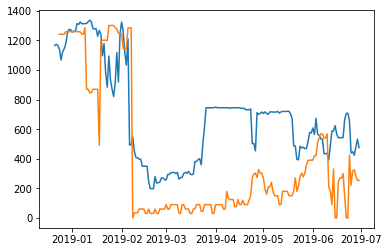

In [157]:
# plot comparison
plt.plot(df_pred["PredMaxEnergy"].index, df_pred["PredMaxEnergy"])
plt.plot(df.iloc[1920-192:,:].index, df.iloc[1920-192:,:]["Variante Prio"])
plt.legend()

In [167]:
# try adding additional regressors: daily values from previous models

df_MLPprediction = pd.read_csv("ForecastVariante PrioMLP (10,7,1) Act(lin, relu, relu) Dropout (0.1,0.2)+noneexport_dataframe.csv", parse_dates=['Date'], date_parser=dateparse, index_col="Date")
# rename first column 
df_MLPprediction.rename(columns={ df_MLPprediction.columns[0]: "Prediction"}, inplace=True)
df_MLPprediction.head()

,Prediction,Ground truth,Mean train values,Baseline
Date,,,,
2018-12-21,849.08440,1241.052632,727.020546,855.1
2018-12-22,781.52800,1241.052632,727.020546,853.5
2018-12-23,779.63550,1241.052632,727.020546,824.0
2018-12-24,895.75410,1241.052632,727.020546,924.7
2018-12-25,817.40027,1241.052632,727.020546,868.5


In [183]:
np.array([[['PrioH'+str(i),'PrioP'+str(i)][j] for i in range(1,4+1)] for j in range(1+1)]).flatten()

array(['PrioH1', 'PrioH2', 'PrioH3', 'PrioH4', 'PrioP1', 'PrioP2',
       'PrioP3', 'PrioP4'], dtype='<U6')

In [244]:
# remove daily values from the target features
target_features = ['PrioH1', 'PrioP1', 'PrioH2', 'PrioP2', 'PrioH3', 'PrioP3', 'PrioH4', 'PrioP4']
regressors = ['Inflow lake 1 [m3]', \
           'Inflow lake 2 [m3]', 'Inflow lake 3 [m3]', 'Inflow lake 4 [m3]', \
           'Vol lake 1 [%]', 'Availability plant 1 [%]', \
           'Availability plant 2 [%]', 'Availability plant 3 [%]', \
           'Availability plant 4 [%]','Variante Prio']

# implement mutli-output random forest
fullRegressors = regressors
# create list of target features
target_features = np.array([[['PrioH'+str(i),'PrioP'+str(i)][j] for i in range(1,4+1)] for j in range(1+1)]).flatten()

xTrain, xTest, yTrain, yTest =  GetDataSplitMulti(df, fullRegressors, target_features,0.9)
yTest.head()

,PrioH1,PrioH2,PrioH3,PrioH4,PrioP1,PrioP2,PrioP3,PrioP4
Date,,,,,,,,
2018-12-21,2.0,14.0,8.0,0.0,74.942792,65.949657,20.983982,0.0
2018-12-22,2.0,14.0,8.0,0.0,74.942792,65.949657,20.983982,0.0
2018-12-23,2.0,14.0,8.0,0.0,74.942792,65.949657,20.983982,0.0
2018-12-24,2.0,14.0,8.0,0.0,74.942792,65.949657,20.983982,0.0
2018-12-25,2.0,14.0,8.0,0.0,74.942792,65.949657,20.983982,0.0


In [245]:
regr_rf = RandomForestRegressor()
regr_rf.fit(xTrain, yTrain)
# prediction is made with the previously predicted daily maximum energy 
xTest["Variante Prio"] = df_MLPprediction["Prediction"]
pred = regr_rf.predict(xTest)
df_pred = pd.DataFrame(data=pred, columns = target_features, index = yTest.index)
df_pred.head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,PrioH1,PrioH2,PrioH3,PrioH4,PrioP1,PrioP2,PrioP3,PrioP4
Date,,,,,,,,
2018-12-21,4.6,4.1,4.0,7.0,67.914096,51.864691,36.655149,21.646505
2018-12-22,3.2,4.1,5.1,5.2,67.500000,56.850000,41.130000,24.560000
2018-12-23,2.8,4.5,5.2,5.2,68.809153,58.880343,38.062494,20.889029
2018-12-24,5.3,4.7,5.9,0.9,70.320000,55.350000,31.200000,2.220000
2018-12-25,3.3,3.6,3.8,6.5,69.829153,59.600343,44.542494,30.749029


In [246]:
# rounding function is floor
rounding_func = round #math.floor

# hourly dataframe to store restults, out of complete one
df_hourly_pred = df_hourly.loc[df_pred.index.min():,] 

firstDate = df_pred.index.min()
powerHours = np.zeros(4584)

# loop over all date
for myDate in df_pred.index:
    # index is date difference times 24
    index = (myDate-firstDate).days * 24
    # compute hourly vector of original values, using the 4 pairs (power/nb of hours)
    currHour = index
    for iPair in range(1,4+1):
        pwrValue = df_pred.loc[myDate, "PrioP"+str(iPair)]
        nbHours = int(rounding_func(df_pred.loc[myDate, "PrioH"+str(iPair)]))
        if pwrValue > 0:
            #print("Date %s, Pair %i, Pwr %d, Hours %f" %(myDate, iPair, pwrValue, nbHours))
            powerHours[currHour:currHour+nbHours] = pwrValue
            currHour = currHour + nbHours
            
df_hourly_pred["PredictedPower"]= powerHours

# compute error metrics over hourly values calculated above
print('Hourly comparison: prediction vs. actual values')
print('RMSE :'+ str(round(math.sqrt(metrics.mean_squared_error(df_hourly_pred["Power"],df_hourly_pred["PredictedPower"])),2)))
print('MAE :'+ str(round( metrics.mean_absolute_error(df_hourly_pred["Power"],df_hourly_pred["PredictedPower"]),2)))
print('R^2 :'+ str(round(metrics.r2_score( df_hourly_pred["Power"],df_hourly_pred["PredictedPower"])*100, 2)))

Hourly comparison: prediction vs. actual values
RMSE :16.97
MAE :10.65
R^2 :48.42


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [247]:
# scale the target values to predict a profile, i.e. relative values and not absolute ones, for power
# i.e. power to be relative to daily maximum energy (taking advantage of relation linking them together)

maxValuesPerBlock = [df["PrioP"+str(i)].max() for i in range(1,4+1)]
maxValuesPerBlock

[84.0, 75.0, 68.64759725400458, 60.29999999999999]

In [322]:
# add new columns to dataframe with scaled power values
# NB: the definition of produced power "profile" is the sum of scaledPower * NoHours = 1
for i in range(1,4+1):
    scaledPower = np.zeros(len(df.index))
    for myLine in range(len(df.index)):
        #print(i, myLine, df.iloc[myLine,]["Date"], df.iloc[myLine,]["PrioP"+str(i)], df.iloc[myLine,]["Variante Prio"])
        if df.iloc[myLine,]["Variante Prio"]>0:
            scaledPower[myLine] = df.iloc[myLine,]["PrioP"+str(i)] / df.iloc[myLine,]["Variante Prio"] 
        # scale number of hours too
    df["ScaledPowerBlock"+str(i)] =  scaledPower
    df["ScaledHours"+str(i)] = df['PrioH'+str(i)]/24
    
df.fillna(value = 0.0, axis='columns',inplace = True)

In [323]:
df.isnull().any().any()

False

In [324]:
# run the aglorithm again with these new targets

regressors = ['Inflow lake 1 [m3]', \
           'Inflow lake 2 [m3]', 'Inflow lake 3 [m3]', 'Inflow lake 4 [m3]', \
           'Vol lake 1 [%]', 'Availability plant 1 [%]', \
           'Availability plant 2 [%]', 'Availability plant 3 [%]', \
           'Availability plant 4 [%]','Variante Prio']

# implement mutli-output random forest
fullRegressors = regressors
# create list of target features
target_features = np.array([[['ScaledHours'+str(i),'ScaledPowerBlock'+str(i)][j] for i in range(1,4+1)] for j in range(1+1)]).flatten()

xTrain, xTest, yTrain, yTest =  GetDataSplitMulti(df, fullRegressors, target_features,0.9)

yTest.head()

,ScaledHours1,ScaledHours2,ScaledHours3,ScaledHours4,ScaledPowerBlock1,ScaledPowerBlock2,ScaledPowerBlock3,ScaledPowerBlock4
Date,,,,,,,,
2018-12-21,0.083333,0.583333,0.333333,0.0,0.060386,0.05314,0.016908,0.0
2018-12-22,0.083333,0.583333,0.333333,0.0,0.060386,0.05314,0.016908,0.0
2018-12-23,0.083333,0.583333,0.333333,0.0,0.060386,0.05314,0.016908,0.0
2018-12-24,0.083333,0.583333,0.333333,0.0,0.060386,0.05314,0.016908,0.0
2018-12-25,0.083333,0.583333,0.333333,0.0,0.060386,0.05314,0.016908,0.0


In [336]:
regr_rf = RandomForestRegressor()
regr_rf.fit(xTrain, yTrain)

# prediction is made with the previously predicted daily maximum energy 
xTest["Variante Prio"] = df_MLPprediction["Prediction"]
pred = regr_rf.predict(xTest)
df_pred = pd.DataFrame(data=pred, columns = target_features, index = yTest.index)

# rescale to corresponding energy values
df_pred["PredictedMaxEnergy"] = df_MLPprediction["Prediction"]

df_pred["MaxEnergyFromBlocks"] = 0
df_pred["profileSum"] = 0
for i in range(1,4+1):
    df_pred["PrioH"+str(i)] = df_pred["ScaledHours"+str(i)]*24
    df_pred["PrioP"+str(i)] = df_pred["ScaledPowerBlock"+str(i)]*df_pred["PredictedMaxEnergy"]
    # compute "profile sum", i.e sum(scaledpower x nb hours)
    df_pred["profileSum"] += df_pred["ScaledPowerBlock"+str(i)]*df_pred["PrioH1"]
    df_pred["MaxEnergyFromBlocks"] += np.ceil(df_pred["PrioH"+str(i)])*df_pred["PrioP"+str(i)]
df_pred.head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,ScaledHours1,ScaledHours2,ScaledHours3,ScaledHours4,ScaledPowerBlock1,ScaledPowerBlock2,ScaledPowerBlock3,ScaledPowerBlock4,PredictedMaxEnergy,MaxEnergyFromBlocks,profileSum,PrioH1,PrioP1,PrioH2,PrioP2,PrioH3,PrioP3,PrioH4,PrioP4
Date,,,,,,,,,,,,,,,,,,,
2018-12-21,0.175000,0.212500,0.162500,0.220833,0.085299,0.067467,0.042723,0.023190,849.08440,969.084617,0.918451,4.2,72.426058,5.1,57.285151,3.9,36.275052,5.3,19.690535
2018-12-22,0.129167,0.150000,0.175000,0.220833,0.091121,0.077838,0.056518,0.038439,781.52800,929.286123,0.818142,3.1,71.213602,3.6,60.832912,4.2,44.170701,5.3,30.041094
2018-12-23,0.125000,0.162500,0.179167,0.204167,0.092819,0.077782,0.054991,0.037686,779.63550,820.931371,0.789832,3.0,72.364603,3.9,60.641746,4.3,42.872789,4.9,29.381326
2018-12-24,0.166667,0.162500,0.329167,0.008333,0.082243,0.074323,0.047559,0.003075,895.75410,904.541146,0.828799,4.0,73.669500,3.9,66.575393,7.9,42.600928,0.2,2.754149
2018-12-25,0.150000,0.154167,0.170833,0.195833,0.089755,0.076652,0.055967,0.039167,817.40027,932.899529,0.941550,3.6,73.365451,3.7,62.655740,4.1,45.747469,4.7,32.015484


In [327]:
print("Max profile sum: ",df_pred["profileSum"].max())
print("Min profile sum: ",df_pred["profileSum"].min())

Max profile sum:  2.5038670502672185
Min profile sum:  0.5138748444129306


In [337]:
# rounding function is ceiling function
rounding_func = math.ceil 

# hourly dataframe to store restults, out of complete one
df_hourly_pred = df_hourly.loc[df_pred.index.min():,] 

firstDate = df_pred.index.min()
powerHours = np.zeros(4584)

# loop over all date
for myDate in df_pred.index:
    # index is date difference times 24
    index = (myDate-firstDate).days * 24
    # compute hourly vector of original values, using the 4 pairs (power/nb of hours)
    currHour = index
    for iPair in range(1,4+1):
        pwrValue = df_pred.loc[myDate, "PrioP"+str(iPair)]
        nbHours = int(rounding_func(df_pred.loc[myDate, "PrioH"+str(iPair)]))
        if pwrValue > 0:
            #print("Date %s, Pair %i, Pwr %d, Hours %f" %(myDate, iPair, pwrValue, nbHours))
            powerHours[currHour:currHour+nbHours] = pwrValue
            currHour = currHour + nbHours
            
df_hourly_pred["PredictedPower"]= powerHours

# compute error metrics over hourly values calculated above
print('Hourly comparison: prediction vs. actual values')
print('RMSE :'+ str(round(math.sqrt(metrics.mean_squared_error(df_hourly_pred["Power"],df_hourly_pred["PredictedPower"])),2)))
print('MAE :'+ str(round( metrics.mean_absolute_error(df_hourly_pred["Power"],df_hourly_pred["PredictedPower"]),2)))
print('R^2 :'+ str(round(metrics.r2_score( df_hourly_pred["Power"],df_hourly_pred["PredictedPower"])*100, 2)))
print('Mean power value :'+ str(round(df_hourly_pred["Power"].mean(), 2)))

# compare to baseline over this period
df_hourly_period = df_hourly.iloc[int(len(df_hourly.index)*0.9):,]
print('Hourly comparison: prediction baseline vs. actual values')
print('RMSE :'+ str(round(math.sqrt(metrics.mean_squared_error(df_hourly_period["Power"],df_hourly_period["PowerBaseLine"])),2)))
print('MAE :'+ str(round( metrics.mean_absolute_error(df_hourly_period["Power"],df_hourly_period["PowerBaseLine"]),2)))
print('R^2 :'+ str(round(metrics.r2_score( df_hourly_period["Power"],df_hourly_period["PowerBaseLine"])*100, 2)))

#compare daily values: input (predicted by previous algo) and output (computed from prediced blocks)
print('Daily values comparison: prediction (from blocks) vs. input values (predicted previously)')
print('RMSE :'+ str(round(math.sqrt(metrics.mean_squared_error(df_pred["MaxEnergyFromBlocks"],df_pred["PredictedMaxEnergy"])),2)))
print('MAE :'+ str(round( metrics.mean_absolute_error(df_pred["MaxEnergyFromBlocks"],df_pred["PredictedMaxEnergy"]),2)))
print('R^2 :'+ str(round(metrics.r2_score( df_pred["MaxEnergyFromBlocks"],df_pred["PredictedMaxEnergy"])*100, 2)))

Hourly comparison: prediction vs. actual values
RMSE :14.06
MAE :8.78
R^2 :64.56
Mean power value :17.55
Hourly comparison: prediction baseline vs. actual values
RMSE :24.18
MAE :19.05
R^2 :-4.39
Daily values comparison: prediction (from blocks) vs. input values (predicted previously)
RMSE :87.28
MAE :78.03
R^2 :92.08


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


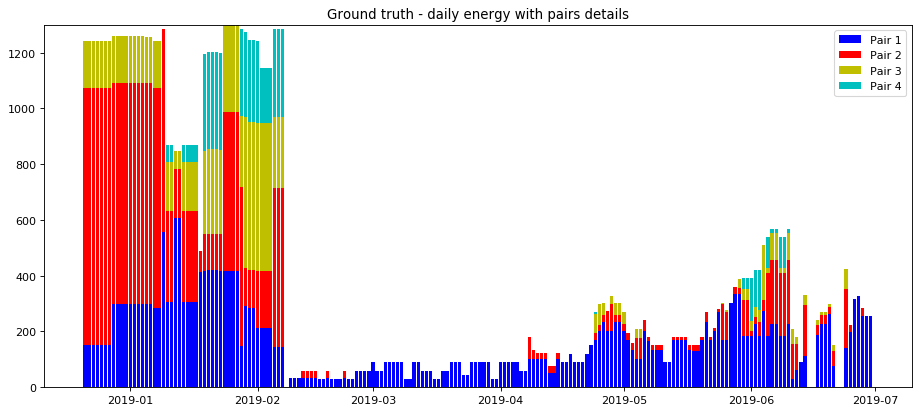

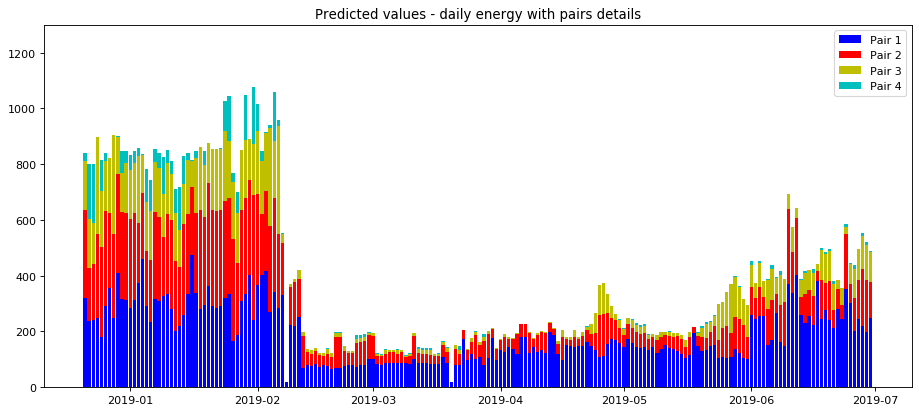

In [333]:
# plot ground truth on test period
    
# loop over lines in the dataframe, check only test occurences
toPlotDataFrames = [df.iloc[int(len(df.index)*0.9):,], df_pred]
labelPlots = ['Ground truth - daily energy with pairs details',
              'Predicted values - daily energy with pairs details']

for (df_plot,labelPlot) in zip(toPlotDataFrames, labelPlots):
    # loop over the 4 pairs : power, nb of hours
    for i in range(1, 4+1):
        df_plot["EnergyPair"+str(i)] = df_plot["PrioH"+str(i)]*df_plot["PrioP"+str(i)]

    # plot stacked graph for total period

    fig=plt.figure(figsize=(14, 6), dpi= 80, edgecolor='k')
    plt.bar(df_plot.index, df_plot.EnergyPair1, color = 'b', label="Pair 1")
    plt.bar(df_plot.index, df_plot.EnergyPair2, color = 'r', bottom = df_plot.EnergyPair1, label="Pair 2")
    plt.bar(df_plot.index, df_plot.EnergyPair3, color = 'y', bottom = df_plot.EnergyPair1+df_plot.EnergyPair2, label="Pair 3")
    plt.bar(df_plot.index, df_plot.EnergyPair4, color = 'c', bottom = df_plot.EnergyPair1+df_plot.EnergyPair2+df_plot.EnergyPair3, label="Pair 4")
    plt.ylim(0, 1400)
    plt.title(labelPlot)
    plt.legend(loc='upper right')
    plt.show()


In [ ]:
# recompute 

In [ ]:
# try with hourly values instead of power blocks
# (no need to reconstruct blocks)

# add 24 columns to dataset
# fill up the columns by filling up a 24 values np.array
# then assign it to dataframe

In [ ]:
# build neural network to do multi-regression 
# -> on power blocks (4 + 4 targets)
# -> same but including previous

## Multi-regression with Multi Layer Perceptron
Here we build a MLP to perform a mutli-output regression, still using previous maximum energy as input
(on top of other inputs)

In [350]:
# defined are xTrain, xTest, yTrain, yTest

#Scale the input data
stScaler = StandardScaler()  
stScaler.fit(xTrain)  
xTrainScaled = stScaler.transform(xTrain)  
xTestScaled = stScaler.transform(xTest) 

OutputTrainH1 = yTrain["ScaledHours1"]
OutputTrainP1 = yTrain["ScaledPowerBlock1"]
OutputTrainH2 = yTrain["ScaledHours2"]
OutputTrainP2 = yTrain["ScaledPowerBlock2"]
OutputTrainH3 = yTrain["ScaledHours3"]
OutputTrainP3 = yTrain["ScaledPowerBlock3"]
OutputTrainH4 = yTrain["ScaledHours4"]
OutputTrainP4 = yTrain["ScaledPowerBlock4"]

OutputTestH1 = yTest["ScaledHours1"]
OutputTestP1 = yTest["ScaledPowerBlock1"]
OutputTestH2 = yTest["ScaledHours2"]
OutputTestP2 = yTest["ScaledPowerBlock2"]
OutputTestH3 = yTest["ScaledHours3"]
OutputTestP3 = yTest["ScaledPowerBlock3"]
OutputTestH4 = yTest["ScaledHours4"]
OutputTestP4 = yTest["ScaledPowerBlock4"]


In [349]:
yTrain.head()

,ScaledHours1,ScaledHours2,ScaledHours3,ScaledHours4,ScaledPowerBlock1,ScaledPowerBlock2,ScaledPowerBlock3,ScaledPowerBlock4
Date,,,,,,,,
2014-04-01,0.166667,0.166667,0.333333,0.0,0.081782,0.073138,0.047540,0.0
2014-04-02,0.166667,0.166667,0.333333,0.0,0.081782,0.073138,0.047540,0.0
2014-04-03,0.166667,0.166667,0.333333,0.0,0.081782,0.073138,0.047540,0.0
2014-04-04,0.166667,0.166667,0.333333,0.0,0.081782,0.073138,0.047540,0.0
2014-04-05,0.166667,0.166667,0.333333,0.0,0.080882,0.073529,0.047794,0.0


In [426]:
# building MLP model with 4x2 outputs
import keras
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
visible = Input(shape=(10,))
hidden1 = Dense(10, activation='relu', name='Hidden1')(visible)
hidden2 = Dense(7, activation='relu', name='Hidden2')(hidden1)
hiddenH3 = Dense(5, activation='relu', name='Hidden13')(hidden2)
hiddenP3 = Dense(5, activation='relu', name='Hidden23')(hidden2)

# output layers use a linear activation function
NbHours1_ouput = Dense(1, activation='linear', name='NbHours1')(hiddenH3) 
NbHours2_ouput = Dense(1, activation='linear', name='NbHours2')(hiddenH3)
NbHours4_ouput = Dense(1, activation='linear', name='NbHours3')(hiddenH3)
NbHours3_ouput = Dense(1, activation='linear', name='NbHours4')(hiddenH3)
power1_output = Dense(1, activation='linear', name='Power1')(hiddenP3)
power2_output = Dense(1, activation='linear', name='Power2')(hiddenP3)
power3_output = Dense(1, activation='linear', name='Power3')(hiddenP3)
power4_output = Dense(1, activation='linear', name='Power4')(hiddenP3)


model = Model(inputs=visible, outputs=[ NbHours1_ouput, NbHours2_ouput, NbHours3_ouput, NbHours4_ouput,
                                        power1_output, power2_output, power3_output, power4_output 
                                      ])
# summarize layers
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
Hidden1 (Dense)                 (None, 10)           110         input_6[0][0]                    
__________________________________________________________________________________________________
Hidden2 (Dense)                 (None, 7)            77          Hidden1[0][0]                    
__________________________________________________________________________________________________
Hidden13 (Dense)                (None, 5)            40          Hidden2[0][0]                    
__________________________________________________________________________________________________
Hidden23 (

In [427]:
model.compile(optimizer='adam',
              loss={'NbHours1': 'mean_squared_error', 'NbHours2': 'mean_squared_error',
                    'NbHours3': 'mean_squared_error', 'NbHours4': 'mean_squared_error',
                    'Power1': 'mean_squared_error', 'Power2': 'mean_squared_error', 
                    'Power3': 'mean_squared_error', 'Power4': 'mean_squared_error'
                   }, 
              loss_weights={ 'NbHours1': 1.0, 'NbHours2': 1.0, 'NbHours3': 1.0, 'NbHours4': 1.0,
                            'Power1': 1.0,'Power2': 1.0,'Power3': 1.0,  'Power4': 1.0 })

history = model.fit(x=xTrainScaled, y=[ OutputTrainH1, OutputTrainH2, OutputTrainH3, OutputTrainH4,
                                        OutputTrainP1, OutputTrainP2, OutputTrainP3,  OutputTrainP4], 
                    validation_data=(xTestScaled,[OutputTestH1, OutputTestH2, OutputTestH3, OutputTestH4 , 
                                                  OutputTestP1, OutputTestP2, OutputTestP3, OutputTestP4]), 
                                     epochs=200, batch_size=8)

Train on 1725 samples, validate on 192 samples
Epoch 1/200
1725/1725 [==============================] - 2s 1ms/step - loss: 0.4380 - NbHours1_loss: 0.0541 - NbHours2_loss: 0.1246 - NbHours4_loss: 0.1162 - NbHours3_loss: 0.0710 - Power1_loss: 0.0231 - Power2_loss: 0.0051 - Power3_loss: 0.0278 - Power4_loss: 0.0160 - val_loss: 0.6486 - val_NbHours1_loss: 0.0412 - val_NbHours2_loss: 0.0938 - val_NbHours4_loss: 0.0511 - val_NbHours3_loss: 0.0471 - val_Power1_loss: 0.0798 - val_Power2_loss: 0.0137 - val_Power3_loss: 0.1957 - val_Power4_loss: 0.1262
Epoch 2/200
1725/1725 [==============================] - 0s 209us/step - loss: 0.1522 - NbHours1_loss: 0.0241 - NbHours2_loss: 0.0273 - NbHours4_loss: 0.0370 - NbHours3_loss: 0.0340 - Power1_loss: 0.0172 - Power2_loss: 0.0033 - Power3_loss: 0.0059 - Power4_loss: 0.0032 - val_loss: 0.3715 - val_NbHours1_loss: 0.0262 - val_NbHours2_loss: 0.0542 - val_NbHours4_loss: 0.0337 - val_NbHours3_loss: 0.0292 - val_Power1_loss: 0.0676 - val_Power2_loss: 0.01

1725/1725 [==============================] - 0s 216us/step - loss: 0.1029 - NbHours1_loss: 0.0187 - NbHours2_loss: 0.0180 - NbHours4_loss: 0.0244 - NbHours3_loss: 0.0270 - Power1_loss: 0.0101 - Power2_loss: 0.0026 - Power3_loss: 0.0017 - Power4_loss: 4.1979e-04 - val_loss: 0.2171 - val_NbHours1_loss: 0.0128 - val_NbHours2_loss: 0.0346 - val_NbHours4_loss: 0.0284 - val_NbHours3_loss: 0.0200 - val_Power1_loss: 0.0908 - val_Power2_loss: 0.0069 - val_Power3_loss: 0.0176 - val_Power4_loss: 0.0060
Epoch 18/200
1725/1725 [==============================] - 0s 219us/step - loss: 0.1012 - NbHours1_loss: 0.0183 - NbHours2_loss: 0.0181 - NbHours4_loss: 0.0240 - NbHours3_loss: 0.0265 - Power1_loss: 0.0098 - Power2_loss: 0.0026 - Power3_loss: 0.0016 - Power4_loss: 4.1526e-04 - val_loss: 0.2454 - val_NbHours1_loss: 0.0115 - val_NbHours2_loss: 0.0375 - val_NbHours4_loss: 0.0359 - val_NbHours3_loss: 0.0252 - val_Power1_loss: 0.0979 - val_Power2_loss: 0.0068 - val_Power3_loss: 0.0229 - val_Power4_loss: 

1725/1725 [==============================] - 0s 213us/step - loss: 0.0808 - NbHours1_loss: 0.0141 - NbHours2_loss: 0.0149 - NbHours4_loss: 0.0186 - NbHours3_loss: 0.0227 - Power1_loss: 0.0064 - Power2_loss: 0.0024 - Power3_loss: 0.0014 - Power4_loss: 3.3705e-04 - val_loss: 0.1793 - val_NbHours1_loss: 0.0275 - val_NbHours2_loss: 0.0341 - val_NbHours4_loss: 0.0275 - val_NbHours3_loss: 0.0227 - val_Power1_loss: 0.0532 - val_Power2_loss: 0.0096 - val_Power3_loss: 0.0039 - val_Power4_loss: 9.5382e-04
Epoch 50/200
1725/1725 [==============================] - 0s 221us/step - loss: 0.0807 - NbHours1_loss: 0.0141 - NbHours2_loss: 0.0149 - NbHours4_loss: 0.0187 - NbHours3_loss: 0.0225 - Power1_loss: 0.0063 - Power2_loss: 0.0024 - Power3_loss: 0.0014 - Power4_loss: 3.3683e-04 - val_loss: 0.2045 - val_NbHours1_loss: 0.0408 - val_NbHours2_loss: 0.0347 - val_NbHours4_loss: 0.0339 - val_NbHours3_loss: 0.0211 - val_Power1_loss: 0.0578 - val_Power2_loss: 0.0094 - val_Power3_loss: 0.0053 - val_Power4_lo

Epoch 65/200
1725/1725 [==============================] - 0s 214us/step - loss: 0.0753 - NbHours1_loss: 0.0127 - NbHours2_loss: 0.0147 - NbHours4_loss: 0.0180 - NbHours3_loss: 0.0204 - Power1_loss: 0.0055 - Power2_loss: 0.0024 - Power3_loss: 0.0014 - Power4_loss: 3.2693e-04 - val_loss: 0.2069 - val_NbHours1_loss: 0.0513 - val_NbHours2_loss: 0.0469 - val_NbHours4_loss: 0.0254 - val_NbHours3_loss: 0.0188 - val_Power1_loss: 0.0525 - val_Power2_loss: 0.0092 - val_Power3_loss: 0.0023 - val_Power4_loss: 3.7155e-04
Epoch 66/200
1725/1725 [==============================] - 0s 211us/step - loss: 0.0754 - NbHours1_loss: 0.0128 - NbHours2_loss: 0.0147 - NbHours4_loss: 0.0180 - NbHours3_loss: 0.0204 - Power1_loss: 0.0055 - Power2_loss: 0.0024 - Power3_loss: 0.0014 - Power4_loss: 3.2884e-04 - val_loss: 0.1893 - val_NbHours1_loss: 0.0340 - val_NbHours2_loss: 0.0385 - val_NbHours4_loss: 0.0321 - val_NbHours3_loss: 0.0207 - val_Power1_loss: 0.0533 - val_Power2_loss: 0.0086 - val_Power3_loss: 0.0019 - 

Epoch 81/200
1725/1725 [==============================] - 0s 209us/step - loss: 0.0724 - NbHours1_loss: 0.0122 - NbHours2_loss: 0.0138 - NbHours4_loss: 0.0172 - NbHours3_loss: 0.0200 - Power1_loss: 0.0051 - Power2_loss: 0.0024 - Power3_loss: 0.0014 - Power4_loss: 3.2516e-04 - val_loss: 0.2155 - val_NbHours1_loss: 0.0459 - val_NbHours2_loss: 0.0371 - val_NbHours4_loss: 0.0305 - val_NbHours3_loss: 0.0389 - val_Power1_loss: 0.0521 - val_Power2_loss: 0.0089 - val_Power3_loss: 0.0017 - val_Power4_loss: 1.8750e-04
Epoch 82/200
1725/1725 [==============================] - 0s 208us/step - loss: 0.0727 - NbHours1_loss: 0.0126 - NbHours2_loss: 0.0138 - NbHours4_loss: 0.0172 - NbHours3_loss: 0.0199 - Power1_loss: 0.0050 - Power2_loss: 0.0024 - Power3_loss: 0.0014 - Power4_loss: 3.2578e-04 - val_loss: 0.1880 - val_NbHours1_loss: 0.0304 - val_NbHours2_loss: 0.0350 - val_NbHours4_loss: 0.0266 - val_NbHours3_loss: 0.0338 - val_Power1_loss: 0.0513 - val_Power2_loss: 0.0091 - val_Power3_loss: 0.0016 - 

Epoch 97/200
1725/1725 [==============================] - 0s 211us/step - loss: 0.0712 - NbHours1_loss: 0.0123 - NbHours2_loss: 0.0136 - NbHours4_loss: 0.0170 - NbHours3_loss: 0.0193 - Power1_loss: 0.0050 - Power2_loss: 0.0024 - Power3_loss: 0.0014 - Power4_loss: 3.2095e-04 - val_loss: 0.2059 - val_NbHours1_loss: 0.0350 - val_NbHours2_loss: 0.0376 - val_NbHours4_loss: 0.0309 - val_NbHours3_loss: 0.0417 - val_Power1_loss: 0.0481 - val_Power2_loss: 0.0111 - val_Power3_loss: 0.0015 - val_Power4_loss: 1.3324e-04
Epoch 98/200
1725/1725 [==============================] - 0s 212us/step - loss: 0.0708 - NbHours1_loss: 0.0122 - NbHours2_loss: 0.0135 - NbHours4_loss: 0.0169 - NbHours3_loss: 0.0194 - Power1_loss: 0.0048 - Power2_loss: 0.0024 - Power3_loss: 0.0014 - Power4_loss: 3.2454e-04 - val_loss: 0.2163 - val_NbHours1_loss: 0.0435 - val_NbHours2_loss: 0.0430 - val_NbHours4_loss: 0.0297 - val_NbHours3_loss: 0.0396 - val_Power1_loss: 0.0477 - val_Power2_loss: 0.0111 - val_Power3_loss: 0.0017 - 

Epoch 113/200
1725/1725 [==============================] - 0s 210us/step - loss: 0.0706 - NbHours1_loss: 0.0123 - NbHours2_loss: 0.0133 - NbHours4_loss: 0.0170 - NbHours3_loss: 0.0193 - Power1_loss: 0.0047 - Power2_loss: 0.0024 - Power3_loss: 0.0014 - Power4_loss: 3.1945e-04 - val_loss: 0.2189 - val_NbHours1_loss: 0.0206 - val_NbHours2_loss: 0.0349 - val_NbHours4_loss: 0.0339 - val_NbHours3_loss: 0.0617 - val_Power1_loss: 0.0548 - val_Power2_loss: 0.0116 - val_Power3_loss: 0.0013 - val_Power4_loss: 1.4826e-04
Epoch 114/200
1725/1725 [==============================] - 0s 222us/step - loss: 0.0701 - NbHours1_loss: 0.0123 - NbHours2_loss: 0.0131 - NbHours4_loss: 0.0166 - NbHours3_loss: 0.0193 - Power1_loss: 0.0047 - Power2_loss: 0.0024 - Power3_loss: 0.0014 - Power4_loss: 3.1951e-04 - val_loss: 0.2084 - val_NbHours1_loss: 0.0228 - val_NbHours2_loss: 0.0375 - val_NbHours4_loss: 0.0277 - val_NbHours3_loss: 0.0566 - val_Power1_loss: 0.0507 - val_Power2_loss: 0.0115 - val_Power3_loss: 0.0015 

Epoch 129/200
1725/1725 [==============================] - 0s 232us/step - loss: 0.0690 - NbHours1_loss: 0.0122 - NbHours2_loss: 0.0128 - NbHours4_loss: 0.0167 - NbHours3_loss: 0.0187 - Power1_loss: 0.0046 - Power2_loss: 0.0024 - Power3_loss: 0.0014 - Power4_loss: 3.1630e-04 - val_loss: 0.2091 - val_NbHours1_loss: 0.0183 - val_NbHours2_loss: 0.0373 - val_NbHours4_loss: 0.0319 - val_NbHours3_loss: 0.0529 - val_Power1_loss: 0.0551 - val_Power2_loss: 0.0119 - val_Power3_loss: 0.0015 - val_Power4_loss: 1.6691e-04
Epoch 130/200
1725/1725 [==============================] - 0s 214us/step - loss: 0.0693 - NbHours1_loss: 0.0120 - NbHours2_loss: 0.0131 - NbHours4_loss: 0.0166 - NbHours3_loss: 0.0190 - Power1_loss: 0.0046 - Power2_loss: 0.0024 - Power3_loss: 0.0014 - Power4_loss: 3.1943e-04 - val_loss: 0.2606 - val_NbHours1_loss: 0.0221 - val_NbHours2_loss: 0.0435 - val_NbHours4_loss: 0.0437 - val_NbHours3_loss: 0.0839 - val_Power1_loss: 0.0539 - val_Power2_loss: 0.0118 - val_Power3_loss: 0.0015 

Epoch 145/200
1725/1725 [==============================] - 0s 270us/step - loss: 0.0686 - NbHours1_loss: 0.0120 - NbHours2_loss: 0.0128 - NbHours4_loss: 0.0166 - NbHours3_loss: 0.0185 - Power1_loss: 0.0045 - Power2_loss: 0.0024 - Power3_loss: 0.0014 - Power4_loss: 3.1686e-04 - val_loss: 0.2046 - val_NbHours1_loss: 0.0249 - val_NbHours2_loss: 0.0472 - val_NbHours4_loss: 0.0239 - val_NbHours3_loss: 0.0451 - val_Power1_loss: 0.0503 - val_Power2_loss: 0.0116 - val_Power3_loss: 0.0014 - val_Power4_loss: 2.0978e-04
Epoch 146/200
1725/1725 [==============================] - 0s 276us/step - loss: 0.0685 - NbHours1_loss: 0.0120 - NbHours2_loss: 0.0127 - NbHours4_loss: 0.0165 - NbHours3_loss: 0.0187 - Power1_loss: 0.0046 - Power2_loss: 0.0024 - Power3_loss: 0.0014 - Power4_loss: 3.1407e-04 - val_loss: 0.2292 - val_NbHours1_loss: 0.0231 - val_NbHours2_loss: 0.0483 - val_NbHours4_loss: 0.0298 - val_NbHours3_loss: 0.0649 - val_Power1_loss: 0.0494 - val_Power2_loss: 0.0119 - val_Power3_loss: 0.0016 

Epoch 161/200
1725/1725 [==============================] - 0s 218us/step - loss: 0.0682 - NbHours1_loss: 0.0120 - NbHours2_loss: 0.0127 - NbHours4_loss: 0.0165 - NbHours3_loss: 0.0182 - Power1_loss: 0.0047 - Power2_loss: 0.0024 - Power3_loss: 0.0014 - Power4_loss: 3.1562e-04 - val_loss: 0.2198 - val_NbHours1_loss: 0.0140 - val_NbHours2_loss: 0.0366 - val_NbHours4_loss: 0.0378 - val_NbHours3_loss: 0.0672 - val_Power1_loss: 0.0509 - val_Power2_loss: 0.0116 - val_Power3_loss: 0.0015 - val_Power4_loss: 1.6570e-04
Epoch 162/200
1725/1725 [==============================] - 0s 264us/step - loss: 0.0685 - NbHours1_loss: 0.0120 - NbHours2_loss: 0.0125 - NbHours4_loss: 0.0168 - NbHours3_loss: 0.0184 - Power1_loss: 0.0047 - Power2_loss: 0.0024 - Power3_loss: 0.0014 - Power4_loss: 3.1491e-04 - val_loss: 0.2121 - val_NbHours1_loss: 0.0152 - val_NbHours2_loss: 0.0400 - val_NbHours4_loss: 0.0335 - val_NbHours3_loss: 0.0593 - val_Power1_loss: 0.0504 - val_Power2_loss: 0.0119 - val_Power3_loss: 0.0016 

Epoch 177/200
1725/1725 [==============================] - 0s 242us/step - loss: 0.0675 - NbHours1_loss: 0.0121 - NbHours2_loss: 0.0123 - NbHours4_loss: 0.0165 - NbHours3_loss: 0.0181 - Power1_loss: 0.0046 - Power2_loss: 0.0024 - Power3_loss: 0.0014 - Power4_loss: 3.1692e-04 - val_loss: 0.2985 - val_NbHours1_loss: 0.0140 - val_NbHours2_loss: 0.0402 - val_NbHours4_loss: 0.0606 - val_NbHours3_loss: 0.1194 - val_Power1_loss: 0.0508 - val_Power2_loss: 0.0119 - val_Power3_loss: 0.0016 - val_Power4_loss: 1.8887e-04
Epoch 178/200
1725/1725 [==============================] - 0s 244us/step - loss: 0.0676 - NbHours1_loss: 0.0119 - NbHours2_loss: 0.0124 - NbHours4_loss: 0.0168 - NbHours3_loss: 0.0179 - Power1_loss: 0.0046 - Power2_loss: 0.0023 - Power3_loss: 0.0014 - Power4_loss: 3.1921e-04 - val_loss: 0.2167 - val_NbHours1_loss: 0.0108 - val_NbHours2_loss: 0.0306 - val_NbHours4_loss: 0.0373 - val_NbHours3_loss: 0.0748 - val_Power1_loss: 0.0493 - val_Power2_loss: 0.0121 - val_Power3_loss: 0.0017 

dict_keys(['val_loss', 'val_NbHours1_loss', 'val_NbHours2_loss', 'val_NbHours4_loss', 'val_NbHours3_loss', 'val_Power1_loss', 'val_Power2_loss', 'val_Power3_loss', 'val_Power4_loss', 'loss', 'NbHours1_loss', 'NbHours2_loss', 'NbHours4_loss', 'NbHours3_loss', 'Power1_loss', 'Power2_loss', 'Power3_loss', 'Power4_loss'])


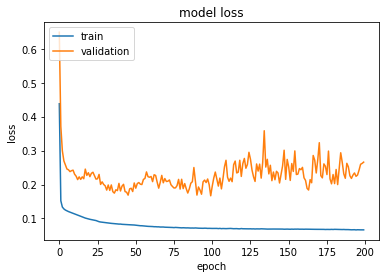

In [428]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [429]:
yPred= model.predict(xTestScaled)
len(yPred[0])

192

In [430]:
yPreNp = np.array(yPred)
yPreNp.transpose()[0].shape

(192, 8)

In [431]:
yTest.columns

Index(['ScaledHours1', 'ScaledHours2', 'ScaledHours3', 'ScaledHours4',
       'ScaledPowerBlock1', 'ScaledPowerBlock2', 'ScaledPowerBlock3',
       'ScaledPowerBlock4'],
      dtype='object')

In [434]:
df_pred = pd.DataFrame(data = yPreNp.transpose()[0], columns = yTest.columns, index = yTest.index)
df_pred.head(5)

,ScaledHours1,ScaledHours2,ScaledHours3,ScaledHours4,ScaledPowerBlock1,ScaledPowerBlock2,ScaledPowerBlock3,ScaledPowerBlock4
Date,,,,,,,,
2018-12-21,0.169246,0.182461,0.183397,0.207927,0.074634,0.068112,0.043064,0.017704
2018-12-22,0.169753,0.181891,0.174261,0.214651,0.074809,0.068487,0.043457,0.017952
2018-12-23,0.169615,0.182046,0.176752,0.212818,0.074761,0.068384,0.043350,0.017885
2018-12-24,0.204813,0.247420,0.204125,0.101257,0.073105,0.062672,0.037131,0.013890
2018-12-25,0.174739,0.201008,0.190202,0.187762,0.074094,0.066948,0.041843,0.016934


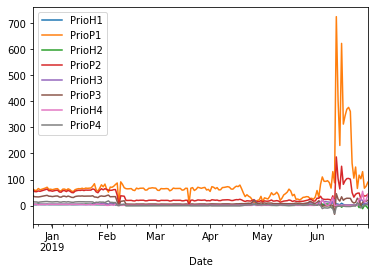

In [433]:
# rescale to corresponding energy values
df_pred["PredictedMaxEnergy"] = df_MLPprediction["Prediction"]

df_pred["MaxEnergyFromBlocks"] = 0
df_pred["profileSum"] = 0
for i in range(1,4+1):
    df_pred["PrioH"+str(i)] = df_pred["ScaledHours"+str(i)]*24
    df_pred["PrioP"+str(i)] = df_pred["ScaledPowerBlock"+str(i)]*df_pred["PredictedMaxEnergy"]
    # compute "profile sum", i.e sum(scaledpower x nb hours)
    df_pred["profileSum"] += df_pred["ScaledPowerBlock"+str(i)]*df_pred["PrioH1"]
    df_pred["MaxEnergyFromBlocks"] += np.ceil(df_pred["PrioH"+str(i)])*df_pred["PrioP"+str(i)]

df_pred[['PrioH1', 'PrioP1', 'PrioH2', 'PrioP2', 'PrioH3',
       'PrioP3', 'PrioH4', 'PrioP4']].plot()

#df_pred.plot(title = 'Power Blocks forecast with MLP')

In [ ]:
# rounding function is ceiling function
rounding_func = math.ceil 

# hourly dataframe to store restults, out of complete one
df_hourly_pred = df_hourly.loc[df_pred.index.min():,] 

firstDate = df_pred.index.min()
powerHours = np.zeros(4584)

# loop over all date
for myDate in df_pred.index:
    # index is date difference times 24
    index = (myDate-firstDate).days * 24
    # compute hourly vector of original values, using the 4 pairs (power/nb of hours)
    currHour = index
    for iPair in range(1,4+1):
        pwrValue = df_pred.loc[myDate, "PrioP"+str(iPair)]
        nbHours = int(rounding_func(df_pred.loc[myDate, "PrioH"+str(iPair)]))
        if pwrValue > 0:
            #print("Date %s, Pair %i, Pwr %d, Hours %f" %(myDate, iPair, pwrValue, nbHours))
            powerHours[currHour:currHour+nbHours] = pwrValue
            currHour = currHour + nbHours
            
df_hourly_pred["PredictedPower"]= powerHours

# compute error metrics over hourly values calculated above
print('Hourly comparison: prediction vs. actual values')
print('RMSE :'+ str(round(math.sqrt(metrics.mean_squared_error(df_hourly_pred["Power"],df_hourly_pred["PredictedPower"])),2)))
print('MAE :'+ str(round( metrics.mean_absolute_error(df_hourly_pred["Power"],df_hourly_pred["PredictedPower"]),2)))
print('R^2 :'+ str(round(metrics.r2_score( df_hourly_pred["Power"],df_hourly_pred["PredictedPower"])*100, 2)))
print('Mean power value :'+ str(round(df_hourly_pred["Power"].mean(), 2)))

# compare to baseline over this period
df_hourly_period = df_hourly.iloc[int(len(df_hourly.index)*0.9):,]
print('Hourly comparison: prediction baseline vs. actual values')
print('RMSE :'+ str(round(math.sqrt(metrics.mean_squared_error(df_hourly_period["Power"],df_hourly_period["PowerBaseLine"])),2)))
print('MAE :'+ str(round( metrics.mean_absolute_error(df_hourly_period["Power"],df_hourly_period["PowerBaseLine"]),2)))
print('R^2 :'+ str(round(metrics.r2_score( df_hourly_period["Power"],df_hourly_period["PowerBaseLine"])*100, 2)))

#compare daily values: input (predicted by previous algo) and output (computed from prediced blocks)
print('Daily values comparison: prediction (from blocks) vs. input values (predicted previously)')
print('RMSE :'+ str(round(math.sqrt(metrics.mean_squared_error(df_pred["MaxEnergyFromBlocks"],df_pred["PredictedMaxEnergy"])),2)))
print('MAE :'+ str(round( metrics.mean_absolute_error(df_pred["MaxEnergyFromBlocks"],df_pred["PredictedMaxEnergy"]),2)))
print('R^2 :'+ str(round(metrics.r2_score( df_pred["MaxEnergyFromBlocks"],df_pred["PredictedMaxEnergy"])*100, 2)))